# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

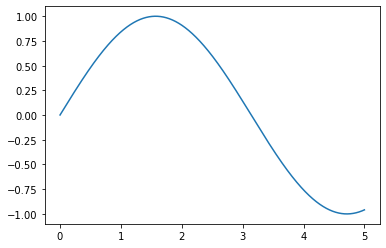

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

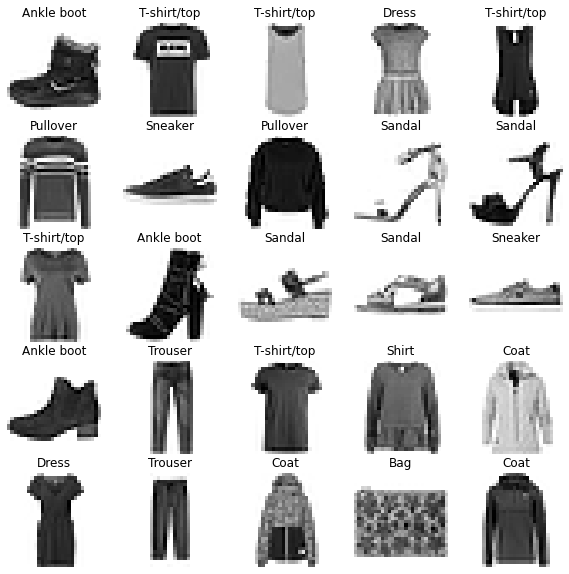

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Train on 60000 samples
Epoch 1/5


   32/60000 [..............................] - ETA: 11:41 - loss: 2.4660 - accuracy: 0.1250

  960/60000 [..............................] - ETA: 26s - loss: 1.3747 - accuracy: 0.5479  

 1920/60000 [..............................] - ETA: 14s - loss: 1.1190 - accuracy: 0.6323

 2848/60000 [>.............................] - ETA: 10s - loss: 0.9889 - accuracy: 0.6710

 3776/60000 [>.............................] - ETA: 8s - loss: 0.9206 - accuracy: 0.6925 

 4704/60000 [=>............................] - ETA: 7s - loss: 0.8738 - accuracy: 0.7083

 5600/60000 [=>............................] - ETA: 6s - loss: 0.8348 - accuracy: 0.7198

 6528/60000 [==>...........................] - ETA: 5s - loss: 0.8091 - accuracy: 0.7244

 7456/60000 [==>...........................] - ETA: 5s - loss: 0.7815 - accuracy: 0.7302

 8384/60000 [===>..........................] - ETA: 5s - loss: 0.7513 - accuracy: 0.7408

 9280/60000 [===>..........................] - ETA: 4s - loss: 0.7292 - accuracy: 0.7496

10176/60000 [====>.........................] - ETA: 4s - loss: 0.7133 - accuracy: 0.7556

11104/60000 [====>.........................] - ETA: 4s - loss: 0.6992 - accuracy: 0.7604

12000/60000 [=====>........................] - ETA: 4s - loss: 0.6906 - accuracy: 0.7641

12864/60000 [=====>........................] - ETA: 3s - loss: 0.6776 - accuracy: 0.7677

13792/60000 [=====>........................] - ETA: 3s - loss: 0.6632 - accuracy: 0.7725

14656/60000 [======>.......................] - ETA: 3s - loss: 0.6560 - accuracy: 0.7745

15584/60000 [======>.......................] - ETA: 3s - loss: 0.6454 - accuracy: 0.7782

16512/60000 [=======>......................] - ETA: 3s - loss: 0.6368 - accuracy: 0.7808

17408/60000 [=======>......................] - ETA: 3s - loss: 0.6309 - accuracy: 0.7829

18336/60000 [========>.....................] - ETA: 3s - loss: 0.6238 - accuracy: 0.7849

19264/60000 [========>.....................] - ETA: 3s - loss: 0.6194 - accuracy: 0.7863

20160/60000 [=========>....................] - ETA: 2s - loss: 0.6147 - accuracy: 0.7879

21056/60000 [=========>....................] - ETA: 2s - loss: 0.6089 - accuracy: 0.7900

21984/60000 [=========>....................] - ETA: 2s - loss: 0.6002 - accuracy: 0.7934

22912/60000 [==========>...................] - ETA: 2s - loss: 0.5962 - accuracy: 0.7951

23840/60000 [==========>...................] - ETA: 2s - loss: 0.5905 - accuracy: 0.7969

24768/60000 [===========>..................] - ETA: 2s - loss: 0.5897 - accuracy: 0.7969

25728/60000 [===========>..................] - ETA: 2s - loss: 0.5857 - accuracy: 0.7983

26656/60000 [============>.................] - ETA: 2s - loss: 0.5805 - accuracy: 0.8004

27488/60000 [============>.................] - ETA: 2s - loss: 0.5768 - accuracy: 0.8015

28384/60000 [=============>................] - ETA: 2s - loss: 0.5730 - accuracy: 0.8031

29312/60000 [=============>................] - ETA: 2s - loss: 0.5702 - accuracy: 0.8040

30208/60000 [==============>...............] - ETA: 2s - loss: 0.5672 - accuracy: 0.8046

31072/60000 [==============>...............] - ETA: 1s - loss: 0.5641 - accuracy: 0.8055

31808/60000 [==============>...............] - ETA: 1s - loss: 0.5617 - accuracy: 0.8062

32736/60000 [===============>..............] - ETA: 1s - loss: 0.5580 - accuracy: 0.8075

33664/60000 [===============>..............] - ETA: 1s - loss: 0.5551 - accuracy: 0.8084

34560/60000 [================>.............] - ETA: 1s - loss: 0.5510 - accuracy: 0.8094

35488/60000 [================>.............] - ETA: 1s - loss: 0.5477 - accuracy: 0.8103

36352/60000 [=================>............] - ETA: 1s - loss: 0.5463 - accuracy: 0.8105

37280/60000 [=================>............] - ETA: 1s - loss: 0.5433 - accuracy: 0.8115

38208/60000 [==================>...........] - ETA: 1s - loss: 0.5404 - accuracy: 0.8125

39136/60000 [==================>...........] - ETA: 1s - loss: 0.5368 - accuracy: 0.8138

40032/60000 [===================>..........] - ETA: 1s - loss: 0.5345 - accuracy: 0.8145

40960/60000 [===================>..........] - ETA: 1s - loss: 0.5326 - accuracy: 0.8152

41888/60000 [===================>..........] - ETA: 1s - loss: 0.5305 - accuracy: 0.8162

42816/60000 [====================>.........] - ETA: 1s - loss: 0.5286 - accuracy: 0.8167

43680/60000 [====================>.........] - ETA: 1s - loss: 0.5267 - accuracy: 0.8172

44480/60000 [=====================>........] - ETA: 1s - loss: 0.5242 - accuracy: 0.8181

45376/60000 [=====================>........] - ETA: 0s - loss: 0.5222 - accuracy: 0.8188

45920/60000 [=====================>........] - ETA: 0s - loss: 0.5209 - accuracy: 0.8191

46816/60000 [======================>.......] - ETA: 0s - loss: 0.5200 - accuracy: 0.8194

47712/60000 [======================>.......] - ETA: 0s - loss: 0.5177 - accuracy: 0.8200

48640/60000 [=======================>......] - ETA: 0s - loss: 0.5160 - accuracy: 0.8203

49568/60000 [=======================>......] - ETA: 0s - loss: 0.5154 - accuracy: 0.8206

50400/60000 [========================>.....] - ETA: 0s - loss: 0.5136 - accuracy: 0.8213

51296/60000 [========================>.....] - ETA: 0s - loss: 0.5125 - accuracy: 0.8218

52192/60000 [=========================>....] - ETA: 0s - loss: 0.5104 - accuracy: 0.8223

53120/60000 [=========================>....] - ETA: 0s - loss: 0.5082 - accuracy: 0.8231

54016/60000 [==========================>...] - ETA: 0s - loss: 0.5065 - accuracy: 0.8237

54944/60000 [==========================>...] - ETA: 0s - loss: 0.5045 - accuracy: 0.8243

55840/60000 [==========================>...] - ETA: 0s - loss: 0.5027 - accuracy: 0.8249

56736/60000 [===========================>..] - ETA: 0s - loss: 0.5020 - accuracy: 0.8252

57664/60000 [===========================>..] - ETA: 0s - loss: 0.5000 - accuracy: 0.8259

58560/60000 [============================>.] - ETA: 0s - loss: 0.4979 - accuracy: 0.8266

59488/60000 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.8268

60000/60000 [==============================] - 4s 63us/sample - loss: 0.4954 - accuracy: 0.8272


Epoch 2/5
   32/60000 [..............................] - ETA: 5s - loss: 0.2882 - accuracy: 0.8750

  960/60000 [..............................] - ETA: 3s - loss: 0.3889 - accuracy: 0.8552

 1888/60000 [..............................] - ETA: 3s - loss: 0.3968 - accuracy: 0.8607

 2816/60000 [>.............................] - ETA: 3s - loss: 0.4006 - accuracy: 0.8597

 3744/60000 [>.............................] - ETA: 3s - loss: 0.3967 - accuracy: 0.8614

 4672/60000 [=>............................] - ETA: 3s - loss: 0.4030 - accuracy: 0.8564

 5600/60000 [=>............................] - ETA: 3s - loss: 0.4015 - accuracy: 0.8570

 6528/60000 [==>...........................] - ETA: 2s - loss: 0.3987 - accuracy: 0.8578

 7456/60000 [==>...........................] - ETA: 2s - loss: 0.3950 - accuracy: 0.8582

 8384/60000 [===>..........................] - ETA: 2s - loss: 0.3947 - accuracy: 0.8579

 9312/60000 [===>..........................] - ETA: 2s - loss: 0.3974 - accuracy: 0.8560

10112/60000 [====>.........................] - ETA: 2s - loss: 0.3991 - accuracy: 0.8559

11040/60000 [====>.........................] - ETA: 2s - loss: 0.4010 - accuracy: 0.8554

12000/60000 [=====>........................] - ETA: 2s - loss: 0.3991 - accuracy: 0.8552

12896/60000 [=====>........................] - ETA: 2s - loss: 0.3979 - accuracy: 0.8565

13824/60000 [=====>........................] - ETA: 2s - loss: 0.3982 - accuracy: 0.8572

14752/60000 [======>.......................] - ETA: 2s - loss: 0.3968 - accuracy: 0.8578

15648/60000 [======>.......................] - ETA: 2s - loss: 0.3938 - accuracy: 0.8585

16576/60000 [=======>......................] - ETA: 2s - loss: 0.3948 - accuracy: 0.8580

17472/60000 [=======>......................] - ETA: 2s - loss: 0.3940 - accuracy: 0.8585

18400/60000 [========>.....................] - ETA: 2s - loss: 0.3913 - accuracy: 0.8593

19328/60000 [========>.....................] - ETA: 2s - loss: 0.3902 - accuracy: 0.8597

20256/60000 [=========>....................] - ETA: 2s - loss: 0.3913 - accuracy: 0.8591

21184/60000 [=========>....................] - ETA: 2s - loss: 0.3903 - accuracy: 0.8594

22112/60000 [==========>...................] - ETA: 2s - loss: 0.3905 - accuracy: 0.8593

23072/60000 [==========>...................] - ETA: 2s - loss: 0.3898 - accuracy: 0.8597

24000/60000 [===========>..................] - ETA: 1s - loss: 0.3898 - accuracy: 0.8592

24896/60000 [===========>..................] - ETA: 1s - loss: 0.3891 - accuracy: 0.8593

25856/60000 [===========>..................] - ETA: 1s - loss: 0.3895 - accuracy: 0.8589

26784/60000 [============>.................] - ETA: 1s - loss: 0.3891 - accuracy: 0.8592

27712/60000 [============>.................] - ETA: 1s - loss: 0.3883 - accuracy: 0.8596

28608/60000 [=============>................] - ETA: 1s - loss: 0.3865 - accuracy: 0.8602

29536/60000 [=============>................] - ETA: 1s - loss: 0.3855 - accuracy: 0.8604

30464/60000 [==============>...............] - ETA: 1s - loss: 0.3840 - accuracy: 0.8608

31392/60000 [==============>...............] - ETA: 1s - loss: 0.3827 - accuracy: 0.8613

32320/60000 [===============>..............] - ETA: 1s - loss: 0.3820 - accuracy: 0.8617

33216/60000 [===============>..............] - ETA: 1s - loss: 0.3818 - accuracy: 0.8615

34144/60000 [================>.............] - ETA: 1s - loss: 0.3818 - accuracy: 0.8614

35072/60000 [================>.............] - ETA: 1s - loss: 0.3827 - accuracy: 0.8609

36000/60000 [=================>............] - ETA: 1s - loss: 0.3823 - accuracy: 0.8611

36928/60000 [=================>............] - ETA: 1s - loss: 0.3815 - accuracy: 0.8615

37824/60000 [=================>............] - ETA: 1s - loss: 0.3806 - accuracy: 0.8620

38752/60000 [==================>...........] - ETA: 1s - loss: 0.3798 - accuracy: 0.8622

39680/60000 [==================>...........] - ETA: 1s - loss: 0.3795 - accuracy: 0.8623

40608/60000 [===================>..........] - ETA: 1s - loss: 0.3796 - accuracy: 0.8623

41536/60000 [===================>..........] - ETA: 1s - loss: 0.3798 - accuracy: 0.8622

42464/60000 [====================>.........] - ETA: 0s - loss: 0.3806 - accuracy: 0.8619

43392/60000 [====================>.........] - ETA: 0s - loss: 0.3811 - accuracy: 0.8616

44320/60000 [=====================>........] - ETA: 0s - loss: 0.3807 - accuracy: 0.8619

45248/60000 [=====================>........] - ETA: 0s - loss: 0.3804 - accuracy: 0.8617

46176/60000 [======================>.......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8620

47008/60000 [======================>.......] - ETA: 0s - loss: 0.3786 - accuracy: 0.8622

47936/60000 [======================>.......] - ETA: 0s - loss: 0.3778 - accuracy: 0.8624

48864/60000 [=======================>......] - ETA: 0s - loss: 0.3774 - accuracy: 0.8627

49792/60000 [=======================>......] - ETA: 0s - loss: 0.3773 - accuracy: 0.8627

50720/60000 [========================>.....] - ETA: 0s - loss: 0.3760 - accuracy: 0.8633

51648/60000 [========================>.....] - ETA: 0s - loss: 0.3750 - accuracy: 0.8637

52576/60000 [=========================>....] - ETA: 0s - loss: 0.3749 - accuracy: 0.8638

53504/60000 [=========================>....] - ETA: 0s - loss: 0.3745 - accuracy: 0.8639

54400/60000 [==========================>...] - ETA: 0s - loss: 0.3738 - accuracy: 0.8641

55328/60000 [==========================>...] - ETA: 0s - loss: 0.3737 - accuracy: 0.8644

56256/60000 [===========================>..] - ETA: 0s - loss: 0.3737 - accuracy: 0.8643

57184/60000 [===========================>..] - ETA: 0s - loss: 0.3731 - accuracy: 0.8645

58112/60000 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8645

59040/60000 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8646

59968/60000 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8648

60000/60000 [==============================] - 3s 55us/sample - loss: 0.3722 - accuracy: 0.8648


Epoch 3/5
   32/60000 [..............................] - ETA: 7s - loss: 0.4063 - accuracy: 0.8750

  960/60000 [..............................] - ETA: 3s - loss: 0.3460 - accuracy: 0.8740

 1888/60000 [..............................] - ETA: 3s - loss: 0.3403 - accuracy: 0.8766

 2816/60000 [>.............................] - ETA: 3s - loss: 0.3421 - accuracy: 0.8754

 3712/60000 [>.............................] - ETA: 3s - loss: 0.3505 - accuracy: 0.8750

 4640/60000 [=>............................] - ETA: 3s - loss: 0.3458 - accuracy: 0.8769

 5536/60000 [=>............................] - ETA: 3s - loss: 0.3446 - accuracy: 0.8775

 6464/60000 [==>...........................] - ETA: 2s - loss: 0.3402 - accuracy: 0.8789

 7392/60000 [==>...........................] - ETA: 2s - loss: 0.3402 - accuracy: 0.8778

 8320/60000 [===>..........................] - ETA: 2s - loss: 0.3461 - accuracy: 0.8767

 9216/60000 [===>..........................] - ETA: 2s - loss: 0.3413 - accuracy: 0.8773

10112/60000 [====>.........................] - ETA: 2s - loss: 0.3385 - accuracy: 0.8777

11040/60000 [====>.........................] - ETA: 2s - loss: 0.3381 - accuracy: 0.8782

11968/60000 [====>.........................] - ETA: 2s - loss: 0.3389 - accuracy: 0.8787

12896/60000 [=====>........................] - ETA: 2s - loss: 0.3375 - accuracy: 0.8788

13824/60000 [=====>........................] - ETA: 2s - loss: 0.3359 - accuracy: 0.8794

14752/60000 [======>.......................] - ETA: 2s - loss: 0.3349 - accuracy: 0.8791

15552/60000 [======>.......................] - ETA: 2s - loss: 0.3351 - accuracy: 0.8783

16384/60000 [=======>......................] - ETA: 2s - loss: 0.3361 - accuracy: 0.8780

17216/60000 [=======>......................] - ETA: 2s - loss: 0.3340 - accuracy: 0.8787

18144/60000 [========>.....................] - ETA: 2s - loss: 0.3357 - accuracy: 0.8787

19072/60000 [========>.....................] - ETA: 2s - loss: 0.3363 - accuracy: 0.8779

19968/60000 [========>.....................] - ETA: 2s - loss: 0.3391 - accuracy: 0.8769

20864/60000 [=========>....................] - ETA: 2s - loss: 0.3388 - accuracy: 0.8766

21792/60000 [=========>....................] - ETA: 2s - loss: 0.3366 - accuracy: 0.8776

22752/60000 [==========>...................] - ETA: 2s - loss: 0.3366 - accuracy: 0.8778

23648/60000 [==========>...................] - ETA: 2s - loss: 0.3370 - accuracy: 0.8776

24576/60000 [===========>..................] - ETA: 1s - loss: 0.3375 - accuracy: 0.8772

25504/60000 [===========>..................] - ETA: 1s - loss: 0.3364 - accuracy: 0.8776

26432/60000 [============>.................] - ETA: 1s - loss: 0.3363 - accuracy: 0.8779

27328/60000 [============>.................] - ETA: 1s - loss: 0.3353 - accuracy: 0.8784

28288/60000 [=============>................] - ETA: 1s - loss: 0.3357 - accuracy: 0.8787

29248/60000 [=============>................] - ETA: 1s - loss: 0.3356 - accuracy: 0.8789

30176/60000 [==============>...............] - ETA: 1s - loss: 0.3358 - accuracy: 0.8787

31104/60000 [==============>...............] - ETA: 1s - loss: 0.3357 - accuracy: 0.8787

32032/60000 [===============>..............] - ETA: 1s - loss: 0.3353 - accuracy: 0.8789

32960/60000 [===============>..............] - ETA: 1s - loss: 0.3340 - accuracy: 0.8795

33888/60000 [===============>..............] - ETA: 1s - loss: 0.3334 - accuracy: 0.8796

34784/60000 [================>.............] - ETA: 1s - loss: 0.3331 - accuracy: 0.8795

35712/60000 [================>.............] - ETA: 1s - loss: 0.3328 - accuracy: 0.8798

36640/60000 [=================>............] - ETA: 1s - loss: 0.3319 - accuracy: 0.8801

37568/60000 [=================>............] - ETA: 1s - loss: 0.3315 - accuracy: 0.8803

38496/60000 [==================>...........] - ETA: 1s - loss: 0.3314 - accuracy: 0.8802

39392/60000 [==================>...........] - ETA: 1s - loss: 0.3326 - accuracy: 0.8797

40320/60000 [===================>..........] - ETA: 1s - loss: 0.3329 - accuracy: 0.8795

41216/60000 [===================>..........] - ETA: 1s - loss: 0.3328 - accuracy: 0.8794

42112/60000 [====================>.........] - ETA: 0s - loss: 0.3331 - accuracy: 0.8793

43008/60000 [====================>.........] - ETA: 0s - loss: 0.3326 - accuracy: 0.8797

43936/60000 [====================>.........] - ETA: 0s - loss: 0.3325 - accuracy: 0.8795

44864/60000 [=====================>........] - ETA: 0s - loss: 0.3325 - accuracy: 0.8795

45760/60000 [=====================>........] - ETA: 0s - loss: 0.3339 - accuracy: 0.8792

46688/60000 [======================>.......] - ETA: 0s - loss: 0.3338 - accuracy: 0.8792

47616/60000 [======================>.......] - ETA: 0s - loss: 0.3338 - accuracy: 0.8792

48416/60000 [=======================>......] - ETA: 0s - loss: 0.3337 - accuracy: 0.8792

49312/60000 [=======================>......] - ETA: 0s - loss: 0.3346 - accuracy: 0.8789

50240/60000 [========================>.....] - ETA: 0s - loss: 0.3354 - accuracy: 0.8785

51168/60000 [========================>.....] - ETA: 0s - loss: 0.3350 - accuracy: 0.8785

52096/60000 [=========================>....] - ETA: 0s - loss: 0.3344 - accuracy: 0.8788

52992/60000 [=========================>....] - ETA: 0s - loss: 0.3353 - accuracy: 0.8783

53920/60000 [=========================>....] - ETA: 0s - loss: 0.3352 - accuracy: 0.8782

54848/60000 [==========================>...] - ETA: 0s - loss: 0.3357 - accuracy: 0.8780

55744/60000 [==========================>...] - ETA: 0s - loss: 0.3351 - accuracy: 0.8781

56672/60000 [===========================>..] - ETA: 0s - loss: 0.3354 - accuracy: 0.8782

57600/60000 [===========================>..] - ETA: 0s - loss: 0.3352 - accuracy: 0.8782

58528/60000 [============================>.] - ETA: 0s - loss: 0.3341 - accuracy: 0.8786

59456/60000 [============================>.] - ETA: 0s - loss: 0.3347 - accuracy: 0.8783

60000/60000 [==============================] - 3s 56us/sample - loss: 0.3348 - accuracy: 0.8783


Epoch 4/5
   32/60000 [..............................] - ETA: 4s - loss: 0.3404 - accuracy: 0.8438

  992/60000 [..............................] - ETA: 3s - loss: 0.2762 - accuracy: 0.9032

 1920/60000 [..............................] - ETA: 3s - loss: 0.2981 - accuracy: 0.8953

 2848/60000 [>.............................] - ETA: 3s - loss: 0.3049 - accuracy: 0.8954

 3808/60000 [>.............................] - ETA: 3s - loss: 0.3094 - accuracy: 0.8923

 4736/60000 [=>............................] - ETA: 3s - loss: 0.3200 - accuracy: 0.8862

 5696/60000 [=>............................] - ETA: 2s - loss: 0.3253 - accuracy: 0.8833

 6592/60000 [==>...........................] - ETA: 2s - loss: 0.3187 - accuracy: 0.8856

 7520/60000 [==>...........................] - ETA: 2s - loss: 0.3168 - accuracy: 0.8866

 8448/60000 [===>..........................] - ETA: 2s - loss: 0.3177 - accuracy: 0.8858

 9376/60000 [===>..........................] - ETA: 2s - loss: 0.3130 - accuracy: 0.8874

10336/60000 [====>.........................] - ETA: 2s - loss: 0.3114 - accuracy: 0.8879

11264/60000 [====>.........................] - ETA: 2s - loss: 0.3062 - accuracy: 0.8899

12192/60000 [=====>........................] - ETA: 2s - loss: 0.3067 - accuracy: 0.8884

13120/60000 [=====>........................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8883

14016/60000 [======>.......................] - ETA: 2s - loss: 0.3075 - accuracy: 0.8880

14912/60000 [======>.......................] - ETA: 2s - loss: 0.3073 - accuracy: 0.8875

15840/60000 [======>.......................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8882

16768/60000 [=======>......................] - ETA: 2s - loss: 0.3073 - accuracy: 0.8883

17696/60000 [=======>......................] - ETA: 2s - loss: 0.3067 - accuracy: 0.8879

18624/60000 [========>.....................] - ETA: 2s - loss: 0.3087 - accuracy: 0.8875

19552/60000 [========>.....................] - ETA: 2s - loss: 0.3090 - accuracy: 0.8872

20480/60000 [=========>....................] - ETA: 2s - loss: 0.3072 - accuracy: 0.8876

21408/60000 [=========>....................] - ETA: 2s - loss: 0.3067 - accuracy: 0.8880

22336/60000 [==========>...................] - ETA: 2s - loss: 0.3054 - accuracy: 0.8886

23264/60000 [==========>...................] - ETA: 2s - loss: 0.3048 - accuracy: 0.8888

24192/60000 [===========>..................] - ETA: 1s - loss: 0.3057 - accuracy: 0.8879

25120/60000 [===========>..................] - ETA: 1s - loss: 0.3068 - accuracy: 0.8876

26048/60000 [============>.................] - ETA: 1s - loss: 0.3065 - accuracy: 0.8882

26976/60000 [============>.................] - ETA: 1s - loss: 0.3062 - accuracy: 0.8882

27904/60000 [============>.................] - ETA: 1s - loss: 0.3078 - accuracy: 0.8874

28800/60000 [=============>................] - ETA: 1s - loss: 0.3064 - accuracy: 0.8881

29696/60000 [=============>................] - ETA: 1s - loss: 0.3070 - accuracy: 0.8877

30624/60000 [==============>...............] - ETA: 1s - loss: 0.3062 - accuracy: 0.8882

31552/60000 [==============>...............] - ETA: 1s - loss: 0.3067 - accuracy: 0.8879

32480/60000 [===============>..............] - ETA: 1s - loss: 0.3069 - accuracy: 0.8880

33408/60000 [===============>..............] - ETA: 1s - loss: 0.3078 - accuracy: 0.8880

34336/60000 [================>.............] - ETA: 1s - loss: 0.3083 - accuracy: 0.8878

35264/60000 [================>.............] - ETA: 1s - loss: 0.3084 - accuracy: 0.8874

36192/60000 [=================>............] - ETA: 1s - loss: 0.3066 - accuracy: 0.8881

37120/60000 [=================>............] - ETA: 1s - loss: 0.3073 - accuracy: 0.8874

38080/60000 [==================>...........] - ETA: 1s - loss: 0.3070 - accuracy: 0.8873

39008/60000 [==================>...........] - ETA: 1s - loss: 0.3078 - accuracy: 0.8872

39936/60000 [==================>...........] - ETA: 1s - loss: 0.3080 - accuracy: 0.8870

40864/60000 [===================>..........] - ETA: 1s - loss: 0.3076 - accuracy: 0.8870

41504/60000 [===================>..........] - ETA: 1s - loss: 0.3076 - accuracy: 0.8870

41952/60000 [===================>..........] - ETA: 1s - loss: 0.3081 - accuracy: 0.8870

42496/60000 [====================>.........] - ETA: 0s - loss: 0.3086 - accuracy: 0.8868

43424/60000 [====================>.........] - ETA: 0s - loss: 0.3093 - accuracy: 0.8865

44352/60000 [=====================>........] - ETA: 0s - loss: 0.3099 - accuracy: 0.8861

45280/60000 [=====================>........] - ETA: 0s - loss: 0.3099 - accuracy: 0.8862

46176/60000 [======================>.......] - ETA: 0s - loss: 0.3111 - accuracy: 0.8860

47008/60000 [======================>.......] - ETA: 0s - loss: 0.3109 - accuracy: 0.8860

47840/60000 [======================>.......] - ETA: 0s - loss: 0.3109 - accuracy: 0.8859

48672/60000 [=======================>......] - ETA: 0s - loss: 0.3103 - accuracy: 0.8862

49568/60000 [=======================>......] - ETA: 0s - loss: 0.3102 - accuracy: 0.8861

50464/60000 [========================>.....] - ETA: 0s - loss: 0.3113 - accuracy: 0.8858

51392/60000 [========================>.....] - ETA: 0s - loss: 0.3102 - accuracy: 0.8863

52320/60000 [=========================>....] - ETA: 0s - loss: 0.3107 - accuracy: 0.8862

53248/60000 [=========================>....] - ETA: 0s - loss: 0.3105 - accuracy: 0.8862

54176/60000 [==========================>...] - ETA: 0s - loss: 0.3104 - accuracy: 0.8863

55104/60000 [==========================>...] - ETA: 0s - loss: 0.3103 - accuracy: 0.8864

56032/60000 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8864

56992/60000 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8863

57920/60000 [===========================>..] - ETA: 0s - loss: 0.3102 - accuracy: 0.8861

58848/60000 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8864

59744/60000 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8863

60000/60000 [==============================] - 3s 56us/sample - loss: 0.3099 - accuracy: 0.8863


Epoch 5/5
   32/60000 [..............................] - ETA: 4s - loss: 0.4009 - accuracy: 0.8750

  928/60000 [..............................] - ETA: 3s - loss: 0.2693 - accuracy: 0.8976

 1856/60000 [..............................] - ETA: 3s - loss: 0.2579 - accuracy: 0.9036

 2784/60000 [>.............................] - ETA: 3s - loss: 0.2627 - accuracy: 0.9009

 3712/60000 [>.............................] - ETA: 3s - loss: 0.2609 - accuracy: 0.9027

 4640/60000 [=>............................] - ETA: 3s - loss: 0.2610 - accuracy: 0.9022

 5536/60000 [=>............................] - ETA: 3s - loss: 0.2630 - accuracy: 0.9026

 6464/60000 [==>...........................] - ETA: 2s - loss: 0.2626 - accuracy: 0.9024

 7392/60000 [==>...........................] - ETA: 2s - loss: 0.2664 - accuracy: 0.9011

 8288/60000 [===>..........................] - ETA: 2s - loss: 0.2713 - accuracy: 0.8982

 9216/60000 [===>..........................] - ETA: 2s - loss: 0.2750 - accuracy: 0.8980

10144/60000 [====>.........................] - ETA: 2s - loss: 0.2793 - accuracy: 0.8958

11072/60000 [====>.........................] - ETA: 2s - loss: 0.2805 - accuracy: 0.8950

12000/60000 [=====>........................] - ETA: 2s - loss: 0.2799 - accuracy: 0.8952

12928/60000 [=====>........................] - ETA: 2s - loss: 0.2821 - accuracy: 0.8946

13856/60000 [=====>........................] - ETA: 2s - loss: 0.2832 - accuracy: 0.8948

14816/60000 [======>.......................] - ETA: 2s - loss: 0.2833 - accuracy: 0.8952

15744/60000 [======>.......................] - ETA: 2s - loss: 0.2825 - accuracy: 0.8953

16672/60000 [=======>......................] - ETA: 2s - loss: 0.2838 - accuracy: 0.8950

17600/60000 [=======>......................] - ETA: 2s - loss: 0.2842 - accuracy: 0.8944

18528/60000 [========>.....................] - ETA: 2s - loss: 0.2863 - accuracy: 0.8935

19456/60000 [========>.....................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8928

20384/60000 [=========>....................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8926

21280/60000 [=========>....................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8934

22208/60000 [==========>...................] - ETA: 2s - loss: 0.2866 - accuracy: 0.8936

23104/60000 [==========>...................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8931

24032/60000 [===========>..................] - ETA: 1s - loss: 0.2891 - accuracy: 0.8926

24928/60000 [===========>..................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8922

25856/60000 [===========>..................] - ETA: 1s - loss: 0.2899 - accuracy: 0.8917

26784/60000 [============>.................] - ETA: 1s - loss: 0.2898 - accuracy: 0.8918

27712/60000 [============>.................] - ETA: 1s - loss: 0.2906 - accuracy: 0.8918

28640/60000 [=============>................] - ETA: 1s - loss: 0.2899 - accuracy: 0.8921

29568/60000 [=============>................] - ETA: 1s - loss: 0.2895 - accuracy: 0.8924

30496/60000 [==============>...............] - ETA: 1s - loss: 0.2886 - accuracy: 0.8925

31424/60000 [==============>...............] - ETA: 1s - loss: 0.2892 - accuracy: 0.8923

32352/60000 [===============>..............] - ETA: 1s - loss: 0.2886 - accuracy: 0.8922

33280/60000 [===============>..............] - ETA: 1s - loss: 0.2879 - accuracy: 0.8927

34208/60000 [================>.............] - ETA: 1s - loss: 0.2880 - accuracy: 0.8927

35136/60000 [================>.............] - ETA: 1s - loss: 0.2871 - accuracy: 0.8928

36064/60000 [=================>............] - ETA: 1s - loss: 0.2871 - accuracy: 0.8931

36992/60000 [=================>............] - ETA: 1s - loss: 0.2877 - accuracy: 0.8929

37632/60000 [=================>............] - ETA: 1s - loss: 0.2883 - accuracy: 0.8926

38528/60000 [==================>...........] - ETA: 1s - loss: 0.2889 - accuracy: 0.8924

39424/60000 [==================>...........] - ETA: 1s - loss: 0.2879 - accuracy: 0.8926

40352/60000 [===================>..........] - ETA: 1s - loss: 0.2882 - accuracy: 0.8926

41280/60000 [===================>..........] - ETA: 1s - loss: 0.2884 - accuracy: 0.8924

42208/60000 [====================>.........] - ETA: 0s - loss: 0.2888 - accuracy: 0.8923

43136/60000 [====================>.........] - ETA: 0s - loss: 0.2891 - accuracy: 0.8921

44032/60000 [=====================>........] - ETA: 0s - loss: 0.2894 - accuracy: 0.8919

44960/60000 [=====================>........] - ETA: 0s - loss: 0.2883 - accuracy: 0.8923

45888/60000 [=====================>........] - ETA: 0s - loss: 0.2885 - accuracy: 0.8924

46816/60000 [======================>.......] - ETA: 0s - loss: 0.2886 - accuracy: 0.8925

47744/60000 [======================>.......] - ETA: 0s - loss: 0.2883 - accuracy: 0.8929

48672/60000 [=======================>......] - ETA: 0s - loss: 0.2885 - accuracy: 0.8929

49600/60000 [=======================>......] - ETA: 0s - loss: 0.2884 - accuracy: 0.8930

50528/60000 [========================>.....] - ETA: 0s - loss: 0.2885 - accuracy: 0.8929

51456/60000 [========================>.....] - ETA: 0s - loss: 0.2883 - accuracy: 0.8929

52384/60000 [=========================>....] - ETA: 0s - loss: 0.2889 - accuracy: 0.8927

53312/60000 [=========================>....] - ETA: 0s - loss: 0.2892 - accuracy: 0.8925

54208/60000 [==========================>...] - ETA: 0s - loss: 0.2892 - accuracy: 0.8924

55104/60000 [==========================>...] - ETA: 0s - loss: 0.2898 - accuracy: 0.8922

56032/60000 [===========================>..] - ETA: 0s - loss: 0.2893 - accuracy: 0.8925

56960/60000 [===========================>..] - ETA: 0s - loss: 0.2887 - accuracy: 0.8929

57888/60000 [===========================>..] - ETA: 0s - loss: 0.2883 - accuracy: 0.8929

58784/60000 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8929

59712/60000 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8928

60000/60000 [==============================] - 3s 55us/sample - loss: 0.2890 - accuracy: 0.8928


Test accuracy: 0.8762


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Test accuracy: 0.8762


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 2:35 - loss: 2.7448 - probe_loss: 2.7448 - probe_accuracy: 0.0500

  680/60000 [..............................] - ETA: 8s - loss: 1.4896 - probe_loss: 1.4896 - probe_accuracy: 0.4721  

 1340/60000 [..............................] - ETA: 6s - loss: 1.2166 - probe_loss: 1.2166 - probe_accuracy: 0.5687

 2000/60000 [>.............................] - ETA: 5s - loss: 1.0519 - probe_loss: 1.0519 - probe_accuracy: 0.6270

 2660/60000 [>.............................] - ETA: 5s - loss: 0.9632 - probe_loss: 0.9632 - probe_accuracy: 0.6639

 3320/60000 [>.............................] - ETA: 5s - loss: 0.9196 - probe_loss: 0.9196 - probe_accuracy: 0.6807

 3980/60000 [>.............................] - ETA: 5s - loss: 0.8771 - probe_loss: 0.8771 - probe_accuracy: 0.6962

 4620/60000 [=>............................] - ETA: 4s - loss: 0.8436 - probe_loss: 0.8436 - probe_accuracy: 0.7069

 5300/60000 [=>............................] - ETA: 4s - loss: 0.8163 - probe_loss: 0.8163 - probe_accuracy: 0.7160

 5960/60000 [=>............................] - ETA: 4s - loss: 0.7858 - probe_loss: 0.7858 - probe_accuracy: 0.7268

 6600/60000 [==>...........................] - ETA: 4s - loss: 0.7693 - probe_loss: 0.7693 - probe_accuracy: 0.7339

 7260/60000 [==>...........................] - ETA: 4s - loss: 0.7451 - probe_loss: 0.7451 - probe_accuracy: 0.7413

 7940/60000 [==>...........................] - ETA: 4s - loss: 0.7254 - probe_loss: 0.7254 - probe_accuracy: 0.7484

 8600/60000 [===>..........................] - ETA: 4s - loss: 0.7137 - probe_loss: 0.7137 - probe_accuracy: 0.7519

 9280/60000 [===>..........................] - ETA: 4s - loss: 0.6991 - probe_loss: 0.6991 - probe_accuracy: 0.7564

 9940/60000 [===>..........................] - ETA: 4s - loss: 0.6870 - probe_loss: 0.6870 - probe_accuracy: 0.7600

10580/60000 [====>.........................] - ETA: 4s - loss: 0.6797 - probe_loss: 0.6797 - probe_accuracy: 0.7624

11240/60000 [====>.........................] - ETA: 3s - loss: 0.6749 - probe_loss: 0.6749 - probe_accuracy: 0.7645

11900/60000 [====>.........................] - ETA: 3s - loss: 0.6666 - probe_loss: 0.6666 - probe_accuracy: 0.7687

12560/60000 [=====>........................] - ETA: 3s - loss: 0.6603 - probe_loss: 0.6603 - probe_accuracy: 0.7704

13220/60000 [=====>........................] - ETA: 3s - loss: 0.6531 - probe_loss: 0.6531 - probe_accuracy: 0.7725

13880/60000 [=====>........................] - ETA: 3s - loss: 0.6466 - probe_loss: 0.6466 - probe_accuracy: 0.7744

14540/60000 [======>.......................] - ETA: 3s - loss: 0.6419 - probe_loss: 0.6419 - probe_accuracy: 0.7758

15200/60000 [======>.......................] - ETA: 3s - loss: 0.6371 - probe_loss: 0.6371 - probe_accuracy: 0.7776

15860/60000 [======>.......................] - ETA: 3s - loss: 0.6333 - probe_loss: 0.6333 - probe_accuracy: 0.7790

16520/60000 [=======>......................] - ETA: 3s - loss: 0.6257 - probe_loss: 0.6257 - probe_accuracy: 0.7820

17160/60000 [=======>......................] - ETA: 3s - loss: 0.6214 - probe_loss: 0.6214 - probe_accuracy: 0.7828

17820/60000 [=======>......................] - ETA: 3s - loss: 0.6175 - probe_loss: 0.6175 - probe_accuracy: 0.7840

18500/60000 [========>.....................] - ETA: 3s - loss: 0.6129 - probe_loss: 0.6129 - probe_accuracy: 0.7854

19160/60000 [========>.....................] - ETA: 3s - loss: 0.6079 - probe_loss: 0.6079 - probe_accuracy: 0.7873

19820/60000 [========>.....................] - ETA: 3s - loss: 0.6041 - probe_loss: 0.6041 - probe_accuracy: 0.7880

20480/60000 [=========>....................] - ETA: 3s - loss: 0.6001 - probe_loss: 0.6001 - probe_accuracy: 0.7890

21140/60000 [=========>....................] - ETA: 3s - loss: 0.5947 - probe_loss: 0.5947 - probe_accuracy: 0.7911

21680/60000 [=========>....................] - ETA: 3s - loss: 0.5914 - probe_loss: 0.5914 - probe_accuracy: 0.7921

22320/60000 [==========>...................] - ETA: 2s - loss: 0.5883 - probe_loss: 0.5883 - probe_accuracy: 0.7932

23000/60000 [==========>...................] - ETA: 2s - loss: 0.5843 - probe_loss: 0.5843 - probe_accuracy: 0.7945

23640/60000 [==========>...................] - ETA: 2s - loss: 0.5814 - probe_loss: 0.5814 - probe_accuracy: 0.7955

24300/60000 [===========>..................] - ETA: 2s - loss: 0.5772 - probe_loss: 0.5772 - probe_accuracy: 0.7969

24940/60000 [===========>..................] - ETA: 2s - loss: 0.5735 - probe_loss: 0.5735 - probe_accuracy: 0.7980

25600/60000 [===========>..................] - ETA: 2s - loss: 0.5705 - probe_loss: 0.5705 - probe_accuracy: 0.7986

26260/60000 [============>.................] - ETA: 2s - loss: 0.5685 - probe_loss: 0.5685 - probe_accuracy: 0.7995

26900/60000 [============>.................] - ETA: 2s - loss: 0.5659 - probe_loss: 0.5659 - probe_accuracy: 0.8005

27500/60000 [============>.................] - ETA: 2s - loss: 0.5637 - probe_loss: 0.5637 - probe_accuracy: 0.8013

28160/60000 [=============>................] - ETA: 2s - loss: 0.5603 - probe_loss: 0.5603 - probe_accuracy: 0.8028

28820/60000 [=============>................] - ETA: 2s - loss: 0.5578 - probe_loss: 0.5578 - probe_accuracy: 0.8039

29500/60000 [=============>................] - ETA: 2s - loss: 0.5557 - probe_loss: 0.5557 - probe_accuracy: 0.8048

30140/60000 [==============>...............] - ETA: 2s - loss: 0.5550 - probe_loss: 0.5550 - probe_accuracy: 0.8048

30800/60000 [==============>...............] - ETA: 2s - loss: 0.5529 - probe_loss: 0.5529 - probe_accuracy: 0.8056

31460/60000 [==============>...............] - ETA: 2s - loss: 0.5519 - probe_loss: 0.5519 - probe_accuracy: 0.8062

32120/60000 [===============>..............] - ETA: 2s - loss: 0.5497 - probe_loss: 0.5497 - probe_accuracy: 0.8069

32700/60000 [===============>..............] - ETA: 2s - loss: 0.5472 - probe_loss: 0.5472 - probe_accuracy: 0.8078

33360/60000 [===============>..............] - ETA: 2s - loss: 0.5442 - probe_loss: 0.5442 - probe_accuracy: 0.8089

34020/60000 [================>.............] - ETA: 2s - loss: 0.5421 - probe_loss: 0.5421 - probe_accuracy: 0.8094

34680/60000 [================>.............] - ETA: 1s - loss: 0.5409 - probe_loss: 0.5409 - probe_accuracy: 0.8099

35360/60000 [================>.............] - ETA: 1s - loss: 0.5397 - probe_loss: 0.5397 - probe_accuracy: 0.8101

36020/60000 [=================>............] - ETA: 1s - loss: 0.5384 - probe_loss: 0.5384 - probe_accuracy: 0.8103

36660/60000 [=================>............] - ETA: 1s - loss: 0.5382 - probe_loss: 0.5382 - probe_accuracy: 0.8104

37340/60000 [=================>............] - ETA: 1s - loss: 0.5361 - probe_loss: 0.5361 - probe_accuracy: 0.8113

38020/60000 [==================>...........] - ETA: 1s - loss: 0.5338 - probe_loss: 0.5338 - probe_accuracy: 0.8121

38660/60000 [==================>...........] - ETA: 1s - loss: 0.5312 - probe_loss: 0.5312 - probe_accuracy: 0.8131

39280/60000 [==================>...........] - ETA: 1s - loss: 0.5297 - probe_loss: 0.5297 - probe_accuracy: 0.8138

39900/60000 [==================>...........] - ETA: 1s - loss: 0.5278 - probe_loss: 0.5278 - probe_accuracy: 0.8144

40560/60000 [===================>..........] - ETA: 1s - loss: 0.5262 - probe_loss: 0.5262 - probe_accuracy: 0.8147

41220/60000 [===================>..........] - ETA: 1s - loss: 0.5251 - probe_loss: 0.5251 - probe_accuracy: 0.8148

41860/60000 [===================>..........] - ETA: 1s - loss: 0.5231 - probe_loss: 0.5231 - probe_accuracy: 0.8155

42520/60000 [====================>.........] - ETA: 1s - loss: 0.5212 - probe_loss: 0.5212 - probe_accuracy: 0.8163

43080/60000 [====================>.........] - ETA: 1s - loss: 0.5202 - probe_loss: 0.5202 - probe_accuracy: 0.8166

43720/60000 [====================>.........] - ETA: 1s - loss: 0.5186 - probe_loss: 0.5186 - probe_accuracy: 0.8172

44260/60000 [=====================>........] - ETA: 1s - loss: 0.5174 - probe_loss: 0.5174 - probe_accuracy: 0.8175

44720/60000 [=====================>........] - ETA: 1s - loss: 0.5166 - probe_loss: 0.5166 - probe_accuracy: 0.8178

45300/60000 [=====================>........] - ETA: 1s - loss: 0.5153 - probe_loss: 0.5153 - probe_accuracy: 0.8182

45960/60000 [=====================>........] - ETA: 1s - loss: 0.5133 - probe_loss: 0.5133 - probe_accuracy: 0.8188

46600/60000 [======================>.......] - ETA: 1s - loss: 0.5120 - probe_loss: 0.5120 - probe_accuracy: 0.8191

47260/60000 [======================>.......] - ETA: 1s - loss: 0.5103 - probe_loss: 0.5103 - probe_accuracy: 0.8198

47920/60000 [======================>.......] - ETA: 0s - loss: 0.5085 - probe_loss: 0.5085 - probe_accuracy: 0.8202

48580/60000 [=======================>......] - ETA: 0s - loss: 0.5071 - probe_loss: 0.5071 - probe_accuracy: 0.8209

49240/60000 [=======================>......] - ETA: 0s - loss: 0.5057 - probe_loss: 0.5057 - probe_accuracy: 0.8212

49900/60000 [=======================>......] - ETA: 0s - loss: 0.5049 - probe_loss: 0.5049 - probe_accuracy: 0.8215

50560/60000 [========================>.....] - ETA: 0s - loss: 0.5041 - probe_loss: 0.5041 - probe_accuracy: 0.8216

51220/60000 [========================>.....] - ETA: 0s - loss: 0.5023 - probe_loss: 0.5023 - probe_accuracy: 0.8223

51860/60000 [========================>.....] - ETA: 0s - loss: 0.5016 - probe_loss: 0.5016 - probe_accuracy: 0.8226

52520/60000 [=========================>....] - ETA: 0s - loss: 0.5005 - probe_loss: 0.5005 - probe_accuracy: 0.8230

53200/60000 [=========================>....] - ETA: 0s - loss: 0.4993 - probe_loss: 0.4993 - probe_accuracy: 0.8235

53860/60000 [=========================>....] - ETA: 0s - loss: 0.4977 - probe_loss: 0.4977 - probe_accuracy: 0.8238

54520/60000 [==========================>...] - ETA: 0s - loss: 0.4969 - probe_loss: 0.4969 - probe_accuracy: 0.8241

55200/60000 [==========================>...] - ETA: 0s - loss: 0.4963 - probe_loss: 0.4963 - probe_accuracy: 0.8245

55840/60000 [==========================>...] - ETA: 0s - loss: 0.4952 - probe_loss: 0.4952 - probe_accuracy: 0.8247

56500/60000 [===========================>..] - ETA: 0s - loss: 0.4945 - probe_loss: 0.4945 - probe_accuracy: 0.8249

57160/60000 [===========================>..] - ETA: 0s - loss: 0.4937 - probe_loss: 0.4937 - probe_accuracy: 0.8252

57820/60000 [===========================>..] - ETA: 0s - loss: 0.4926 - probe_loss: 0.4926 - probe_accuracy: 0.8256

58480/60000 [============================>.] - ETA: 0s - loss: 0.4925 - probe_loss: 0.4925 - probe_accuracy: 0.8255

59140/60000 [============================>.] - ETA: 0s - loss: 0.4920 - probe_loss: 0.4920 - probe_accuracy: 0.8255

59800/60000 [============================>.] - ETA: 0s - loss: 0.4908 - probe_loss: 0.4908 - probe_accuracy: 0.8260

60000/60000 [==============================] - 5s 79us/sample - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8261


Epoch 2/5
   20/60000 [..............................] - ETA: 12s - loss: 0.3944 - probe_loss: 0.3944 - probe_accuracy: 0.8000

  680/60000 [..............................] - ETA: 4s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8662 

 1340/60000 [..............................] - ETA: 4s - loss: 0.3834 - probe_loss: 0.3834 - probe_accuracy: 0.8604

 1960/60000 [..............................] - ETA: 4s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8663

 2620/60000 [>.............................] - ETA: 4s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8634

 3280/60000 [>.............................] - ETA: 4s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8665

 3960/60000 [>.............................] - ETA: 4s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8654

 4600/60000 [=>............................] - ETA: 4s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8654

 5260/60000 [=>............................] - ETA: 4s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8683

 5920/60000 [=>............................] - ETA: 4s - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8693

 6600/60000 [==>...........................] - ETA: 4s - loss: 0.3668 - probe_loss: 0.3668 - probe_accuracy: 0.8694

 7240/60000 [==>...........................] - ETA: 4s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8678

 7920/60000 [==>...........................] - ETA: 4s - loss: 0.3672 - probe_loss: 0.3672 - probe_accuracy: 0.8692

 8580/60000 [===>..........................] - ETA: 3s - loss: 0.3675 - probe_loss: 0.3675 - probe_accuracy: 0.8693

 9220/60000 [===>..........................] - ETA: 3s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8682

 9900/60000 [===>..........................] - ETA: 3s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8686

10560/60000 [====>.........................] - ETA: 3s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8689

11180/60000 [====>.........................] - ETA: 3s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8676

11840/60000 [====>.........................] - ETA: 3s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8672

12500/60000 [=====>........................] - ETA: 3s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8662

13160/60000 [=====>........................] - ETA: 3s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8664

13820/60000 [=====>........................] - ETA: 3s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8660

14480/60000 [======>.......................] - ETA: 3s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8660

15120/60000 [======>.......................] - ETA: 3s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8668

15780/60000 [======>.......................] - ETA: 3s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8663

16420/60000 [=======>......................] - ETA: 3s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8658

17080/60000 [=======>......................] - ETA: 3s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8648

17720/60000 [=======>......................] - ETA: 3s - loss: 0.3786 - probe_loss: 0.3786 - probe_accuracy: 0.8637

18380/60000 [========>.....................] - ETA: 3s - loss: 0.3780 - probe_loss: 0.3780 - probe_accuracy: 0.8637

19020/60000 [========>.....................] - ETA: 3s - loss: 0.3778 - probe_loss: 0.3778 - probe_accuracy: 0.8641

19680/60000 [========>.....................] - ETA: 3s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8645

20340/60000 [=========>....................] - ETA: 3s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8644

21000/60000 [=========>....................] - ETA: 3s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8647

21640/60000 [=========>....................] - ETA: 2s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8637

22300/60000 [==========>...................] - ETA: 2s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8635

22960/60000 [==========>...................] - ETA: 2s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8632

23640/60000 [==========>...................] - ETA: 2s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8635

24300/60000 [===========>..................] - ETA: 2s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8634

24960/60000 [===========>..................] - ETA: 2s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8639

25620/60000 [===========>..................] - ETA: 2s - loss: 0.3795 - probe_loss: 0.3795 - probe_accuracy: 0.8638

26300/60000 [============>.................] - ETA: 2s - loss: 0.3777 - probe_loss: 0.3777 - probe_accuracy: 0.8645

26980/60000 [============>.................] - ETA: 2s - loss: 0.3782 - probe_loss: 0.3782 - probe_accuracy: 0.8643

27660/60000 [============>.................] - ETA: 2s - loss: 0.3774 - probe_loss: 0.3774 - probe_accuracy: 0.8645

28320/60000 [=============>................] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8651

28980/60000 [=============>................] - ETA: 2s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8656

29620/60000 [=============>................] - ETA: 2s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8657

30280/60000 [==============>...............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8658

30940/60000 [==============>...............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8653

31600/60000 [==============>...............] - ETA: 2s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8654

32260/60000 [===============>..............] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8655

32920/60000 [===============>..............] - ETA: 2s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8655

33600/60000 [===============>..............] - ETA: 2s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8652

34280/60000 [================>.............] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8655

34940/60000 [================>.............] - ETA: 1s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8659

35580/60000 [================>.............] - ETA: 1s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8658

36240/60000 [=================>............] - ETA: 1s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8652

36920/60000 [=================>............] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8653

37580/60000 [=================>............] - ETA: 1s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8656

38240/60000 [==================>...........] - ETA: 1s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8658

38900/60000 [==================>...........] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8658

39560/60000 [==================>...........] - ETA: 1s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8658

40220/60000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8658

40880/60000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8658

41540/60000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8656

42220/60000 [====================>.........] - ETA: 1s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8659

42880/60000 [====================>.........] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8659

43540/60000 [====================>.........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8659

44200/60000 [=====================>........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

44860/60000 [=====================>........] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8660

45520/60000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8659

46180/60000 [======================>.......] - ETA: 1s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8655

46780/60000 [======================>.......] - ETA: 1s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8655

47440/60000 [======================>.......] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8659

48100/60000 [=======================>......] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8658

48740/60000 [=======================>......] - ETA: 0s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8660

49400/60000 [=======================>......] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8662

50060/60000 [========================>.....] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8665

50620/60000 [========================>.....] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8663

51260/60000 [========================>.....] - ETA: 0s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8662

51660/60000 [========================>.....] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8664

52320/60000 [=========================>....] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8665

52960/60000 [=========================>....] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8667

53620/60000 [=========================>....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8665

54260/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8666

54920/60000 [==========================>...] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8665

55560/60000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8665

56240/60000 [===========================>..] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8666

56900/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8669

57560/60000 [===========================>..] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8671

58240/60000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8671

58900/60000 [============================>.] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8668

59560/60000 [============================>.] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8669

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8669


Epoch 3/5
   20/60000 [..............................] - ETA: 11s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.9000

  620/60000 [..............................] - ETA: 5s - loss: 0.3529 - probe_loss: 0.3529 - probe_accuracy: 0.8710 

 1280/60000 [..............................] - ETA: 4s - loss: 0.3421 - probe_loss: 0.3421 - probe_accuracy: 0.8789

 1940/60000 [..............................] - ETA: 4s - loss: 0.3494 - probe_loss: 0.3494 - probe_accuracy: 0.8737

 2600/60000 [>.............................] - ETA: 4s - loss: 0.3606 - probe_loss: 0.3606 - probe_accuracy: 0.8665

 3240/60000 [>.............................] - ETA: 4s - loss: 0.3617 - probe_loss: 0.3617 - probe_accuracy: 0.8682

 3900/60000 [>.............................] - ETA: 4s - loss: 0.3567 - probe_loss: 0.3567 - probe_accuracy: 0.8697

 4560/60000 [=>............................] - ETA: 4s - loss: 0.3510 - probe_loss: 0.3510 - probe_accuracy: 0.8708

 5220/60000 [=>............................] - ETA: 4s - loss: 0.3493 - probe_loss: 0.3493 - probe_accuracy: 0.8732

 5900/60000 [=>............................] - ETA: 4s - loss: 0.3564 - probe_loss: 0.3564 - probe_accuracy: 0.8710

 6580/60000 [==>...........................] - ETA: 4s - loss: 0.3543 - probe_loss: 0.3543 - probe_accuracy: 0.8717

 7260/60000 [==>...........................] - ETA: 4s - loss: 0.3522 - probe_loss: 0.3522 - probe_accuracy: 0.8719

 7900/60000 [==>...........................] - ETA: 4s - loss: 0.3517 - probe_loss: 0.3517 - probe_accuracy: 0.8730

 8540/60000 [===>..........................] - ETA: 4s - loss: 0.3469 - probe_loss: 0.3469 - probe_accuracy: 0.8751

 9180/60000 [===>..........................] - ETA: 3s - loss: 0.3484 - probe_loss: 0.3484 - probe_accuracy: 0.8741

 9840/60000 [===>..........................] - ETA: 3s - loss: 0.3467 - probe_loss: 0.3467 - probe_accuracy: 0.8741

10500/60000 [====>.........................] - ETA: 3s - loss: 0.3446 - probe_loss: 0.3446 - probe_accuracy: 0.8750

11160/60000 [====>.........................] - ETA: 3s - loss: 0.3467 - probe_loss: 0.3467 - probe_accuracy: 0.8737

11820/60000 [====>.........................] - ETA: 3s - loss: 0.3443 - probe_loss: 0.3443 - probe_accuracy: 0.8746

12480/60000 [=====>........................] - ETA: 3s - loss: 0.3418 - probe_loss: 0.3418 - probe_accuracy: 0.8752

13140/60000 [=====>........................] - ETA: 3s - loss: 0.3417 - probe_loss: 0.3417 - probe_accuracy: 0.8751

13820/60000 [=====>........................] - ETA: 3s - loss: 0.3401 - probe_loss: 0.3401 - probe_accuracy: 0.8760

14480/60000 [======>.......................] - ETA: 3s - loss: 0.3417 - probe_loss: 0.3417 - probe_accuracy: 0.8756

15140/60000 [======>.......................] - ETA: 3s - loss: 0.3431 - probe_loss: 0.3431 - probe_accuracy: 0.8748

15820/60000 [======>.......................] - ETA: 3s - loss: 0.3422 - probe_loss: 0.3422 - probe_accuracy: 0.8751

16480/60000 [=======>......................] - ETA: 3s - loss: 0.3397 - probe_loss: 0.3397 - probe_accuracy: 0.8766

17140/60000 [=======>......................] - ETA: 3s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8768

17820/60000 [=======>......................] - ETA: 3s - loss: 0.3388 - probe_loss: 0.3388 - probe_accuracy: 0.8767

18480/60000 [========>.....................] - ETA: 3s - loss: 0.3384 - probe_loss: 0.3384 - probe_accuracy: 0.8770

19160/60000 [========>.....................] - ETA: 3s - loss: 0.3394 - probe_loss: 0.3394 - probe_accuracy: 0.8771

19820/60000 [========>.....................] - ETA: 3s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8776

20480/60000 [=========>....................] - ETA: 3s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8776

21140/60000 [=========>....................] - ETA: 2s - loss: 0.3390 - probe_loss: 0.3390 - probe_accuracy: 0.8773

21820/60000 [=========>....................] - ETA: 2s - loss: 0.3395 - probe_loss: 0.3395 - probe_accuracy: 0.8765

22480/60000 [==========>...................] - ETA: 2s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8763

23140/60000 [==========>...................] - ETA: 2s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8772

23760/60000 [==========>...................] - ETA: 2s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8771

24440/60000 [===========>..................] - ETA: 2s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8767

25120/60000 [===========>..................] - ETA: 2s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8770

25800/60000 [===========>..................] - ETA: 2s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8767

26460/60000 [============>.................] - ETA: 2s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8768

27120/60000 [============>.................] - ETA: 2s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8771

27780/60000 [============>.................] - ETA: 2s - loss: 0.3384 - probe_loss: 0.3384 - probe_accuracy: 0.8770

28440/60000 [=============>................] - ETA: 2s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8770

29100/60000 [=============>................] - ETA: 2s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8772

29760/60000 [=============>................] - ETA: 2s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8772

30380/60000 [==============>...............] - ETA: 2s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8773

31040/60000 [==============>...............] - ETA: 2s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8775

31700/60000 [==============>...............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8777

32360/60000 [===============>..............] - ETA: 2s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8777

33020/60000 [===============>..............] - ETA: 2s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8776

33660/60000 [===============>..............] - ETA: 2s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8779

34320/60000 [================>.............] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8782

34980/60000 [================>.............] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8784

35640/60000 [================>.............] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8786

36280/60000 [=================>............] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8785

36920/60000 [=================>............] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8784

37540/60000 [=================>............] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

38200/60000 [==================>...........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8782

38880/60000 [==================>...........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8779

39540/60000 [==================>...........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8779

40200/60000 [===================>..........] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8778

40880/60000 [===================>..........] - ETA: 1s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8782

41560/60000 [===================>..........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8781

42220/60000 [====================>.........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8781

42860/60000 [====================>.........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

43520/60000 [====================>.........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8785

44180/60000 [=====================>........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8783

44820/60000 [=====================>........] - ETA: 1s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8785

45480/60000 [=====================>........] - ETA: 1s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

46140/60000 [======================>.......] - ETA: 1s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8783

46780/60000 [======================>.......] - ETA: 1s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8783

47440/60000 [======================>.......] - ETA: 0s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8784

48100/60000 [=======================>......] - ETA: 0s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8786

48740/60000 [=======================>......] - ETA: 0s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8785

49400/60000 [=======================>......] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8782

50060/60000 [========================>.....] - ETA: 0s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8783

50720/60000 [========================>.....] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8784

51300/60000 [========================>.....] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

51960/60000 [========================>.....] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8782

52620/60000 [=========================>....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8785

53280/60000 [=========================>....] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8785

53940/60000 [=========================>....] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

54620/60000 [==========================>...] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8783

55280/60000 [==========================>...] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8783

55960/60000 [==========================>...] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8784

56580/60000 [===========================>..] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8783

57080/60000 [===========================>..] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8784

57480/60000 [===========================>..] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8785

58140/60000 [============================>.] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8785

58760/60000 [============================>.] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8786

59400/60000 [============================>.] - ETA: 0s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8786

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8785


Epoch 4/5


   20/60000 [..............................] - ETA: 12s - loss: 0.3809 - probe_loss: 0.3809 - probe_accuracy: 0.9000

  660/60000 [..............................] - ETA: 4s - loss: 0.2824 - probe_loss: 0.2824 - probe_accuracy: 0.8909 

 1300/60000 [..............................] - ETA: 4s - loss: 0.2767 - probe_loss: 0.2767 - probe_accuracy: 0.8992

 1960/60000 [..............................] - ETA: 4s - loss: 0.2777 - probe_loss: 0.2777 - probe_accuracy: 0.8990

 2640/60000 [>.............................] - ETA: 4s - loss: 0.2780 - probe_loss: 0.2780 - probe_accuracy: 0.8962

 3300/60000 [>.............................] - ETA: 4s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8891

 3980/60000 [>.............................] - ETA: 4s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8882

 4640/60000 [=>............................] - ETA: 4s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8879

 5320/60000 [=>............................] - ETA: 4s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8867

 5980/60000 [=>............................] - ETA: 4s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8883

 6640/60000 [==>...........................] - ETA: 4s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8887

 7280/60000 [==>...........................] - ETA: 4s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8883

 7940/60000 [==>...........................] - ETA: 4s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8879

 8600/60000 [===>..........................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8878

 9260/60000 [===>..........................] - ETA: 3s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8874

 9920/60000 [===>..........................] - ETA: 3s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8882

10580/60000 [====>.........................] - ETA: 3s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8888

11220/60000 [====>.........................] - ETA: 3s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8881

11860/60000 [====>.........................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8891

12500/60000 [=====>........................] - ETA: 3s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8894

13160/60000 [=====>........................] - ETA: 3s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8888

13820/60000 [=====>........................] - ETA: 3s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8891

14480/60000 [======>.......................] - ETA: 3s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8905

15140/60000 [======>.......................] - ETA: 3s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8897

15800/60000 [======>.......................] - ETA: 3s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8904

16460/60000 [=======>......................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8896

17120/60000 [=======>......................] - ETA: 3s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8894

17780/60000 [=======>......................] - ETA: 3s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8895

18460/60000 [========>.....................] - ETA: 3s - loss: 0.3001 - probe_loss: 0.3001 - probe_accuracy: 0.8898

19120/60000 [========>.....................] - ETA: 3s - loss: 0.3007 - probe_loss: 0.3007 - probe_accuracy: 0.8897

19780/60000 [========>.....................] - ETA: 3s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8888

20420/60000 [=========>....................] - ETA: 3s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8886

21060/60000 [=========>....................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8882

21720/60000 [=========>....................] - ETA: 2s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8883

22360/60000 [==========>...................] - ETA: 2s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8878

23020/60000 [==========>...................] - ETA: 2s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8884

23680/60000 [==========>...................] - ETA: 2s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8889

24340/60000 [===========>..................] - ETA: 2s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8889

24980/60000 [===========>..................] - ETA: 2s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8890

25620/60000 [===========>..................] - ETA: 2s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8896

26280/60000 [============>.................] - ETA: 2s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8892

26940/60000 [============>.................] - ETA: 2s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8886

27620/60000 [============>.................] - ETA: 2s - loss: 0.3054 - probe_loss: 0.3054 - probe_accuracy: 0.8884

28280/60000 [=============>................] - ETA: 2s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8880

28940/60000 [=============>................] - ETA: 2s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8876

29600/60000 [=============>................] - ETA: 2s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8879

30260/60000 [==============>...............] - ETA: 2s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8882

30920/60000 [==============>...............] - ETA: 2s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8880

31580/60000 [==============>...............] - ETA: 2s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8881

32220/60000 [===============>..............] - ETA: 2s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8879

32880/60000 [===============>..............] - ETA: 2s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8877

33540/60000 [===============>..............] - ETA: 2s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8877

34200/60000 [================>.............] - ETA: 1s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

34860/60000 [================>.............] - ETA: 1s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8876

35500/60000 [================>.............] - ETA: 1s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8873

36180/60000 [=================>............] - ETA: 1s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8874

36840/60000 [=================>............] - ETA: 1s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8870

37500/60000 [=================>............] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8865

38140/60000 [==================>...........] - ETA: 1s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8868

38760/60000 [==================>...........] - ETA: 1s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8868

39420/60000 [==================>...........] - ETA: 1s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8869

40060/60000 [===================>..........] - ETA: 1s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8870

40720/60000 [===================>..........] - ETA: 1s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8867

41360/60000 [===================>..........] - ETA: 1s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8865

42000/60000 [====================>.........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8860

42660/60000 [====================>.........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8862

43320/60000 [====================>.........] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8865

43980/60000 [====================>.........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8861

44660/60000 [=====================>........] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8860

45300/60000 [=====================>........] - ETA: 1s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8858

45960/60000 [=====================>........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8861

46620/60000 [======================>.......] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8859

47280/60000 [======================>.......] - ETA: 0s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8861

47940/60000 [======================>.......] - ETA: 0s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8861

48620/60000 [=======================>......] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8864

49280/60000 [=======================>......] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8865

49940/60000 [=======================>......] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8864

50600/60000 [========================>.....] - ETA: 0s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8862

51240/60000 [========================>.....] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8861

51880/60000 [========================>.....] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8862

52540/60000 [=========================>....] - ETA: 0s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8861

53200/60000 [=========================>....] - ETA: 0s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8862

53860/60000 [=========================>....] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8863

54520/60000 [==========================>...] - ETA: 0s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8860

55180/60000 [==========================>...] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8862

55840/60000 [==========================>...] - ETA: 0s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8860

56480/60000 [===========================>..] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8862

57140/60000 [===========================>..] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8861

57800/60000 [===========================>..] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8860

58460/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8862

59120/60000 [============================>.] - ETA: 0s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8863

59780/60000 [============================>.] - ETA: 0s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8864

60000/60000 [==============================] - 5s 77us/sample - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8863


Epoch 5/5
   20/60000 [..............................] - ETA: 12s - loss: 0.2059 - probe_loss: 0.2059 - probe_accuracy: 0.9500

  680/60000 [..............................] - ETA: 4s - loss: 0.2866 - probe_loss: 0.2866 - probe_accuracy: 0.8985 

 1320/60000 [..............................] - ETA: 4s - loss: 0.2749 - probe_loss: 0.2749 - probe_accuracy: 0.9015

 1980/60000 [..............................] - ETA: 4s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8995

 2600/60000 [>.............................] - ETA: 4s - loss: 0.2848 - probe_loss: 0.2848 - probe_accuracy: 0.9004

 3200/60000 [>.............................] - ETA: 4s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.8991

 3840/60000 [>.............................] - ETA: 4s - loss: 0.2853 - probe_loss: 0.2853 - probe_accuracy: 0.8977

 4480/60000 [=>............................] - ETA: 4s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8955

 5140/60000 [=>............................] - ETA: 4s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8955

 5780/60000 [=>............................] - ETA: 4s - loss: 0.2892 - probe_loss: 0.2892 - probe_accuracy: 0.8972

 6440/60000 [==>...........................] - ETA: 4s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8989

 7100/60000 [==>...........................] - ETA: 4s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8987

 7760/60000 [==>...........................] - ETA: 4s - loss: 0.2864 - probe_loss: 0.2864 - probe_accuracy: 0.8987

 8420/60000 [===>..........................] - ETA: 4s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8974

 9080/60000 [===>..........................] - ETA: 4s - loss: 0.2857 - probe_loss: 0.2857 - probe_accuracy: 0.8986

 9740/60000 [===>..........................] - ETA: 3s - loss: 0.2835 - probe_loss: 0.2835 - probe_accuracy: 0.8988

10400/60000 [====>.........................] - ETA: 3s - loss: 0.2851 - probe_loss: 0.2851 - probe_accuracy: 0.8986

11060/60000 [====>.........................] - ETA: 3s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8980

11720/60000 [====>.........................] - ETA: 3s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8978

12360/60000 [=====>........................] - ETA: 3s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8968

13020/60000 [=====>........................] - ETA: 3s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8968

13680/60000 [=====>........................] - ETA: 3s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8969

14340/60000 [======>.......................] - ETA: 3s - loss: 0.2844 - probe_loss: 0.2844 - probe_accuracy: 0.8975

15000/60000 [======>.......................] - ETA: 3s - loss: 0.2849 - probe_loss: 0.2849 - probe_accuracy: 0.8976

15620/60000 [======>.......................] - ETA: 3s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.8974

16280/60000 [=======>......................] - ETA: 3s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8977

16960/60000 [=======>......................] - ETA: 3s - loss: 0.2849 - probe_loss: 0.2849 - probe_accuracy: 0.8969

17620/60000 [=======>......................] - ETA: 3s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8965

18280/60000 [========>.....................] - ETA: 3s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8965

18920/60000 [========>.....................] - ETA: 3s - loss: 0.2844 - probe_loss: 0.2844 - probe_accuracy: 0.8969

19580/60000 [========>.....................] - ETA: 3s - loss: 0.2849 - probe_loss: 0.2849 - probe_accuracy: 0.8968

20260/60000 [=========>....................] - ETA: 3s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8961

20920/60000 [=========>....................] - ETA: 3s - loss: 0.2882 - probe_loss: 0.2882 - probe_accuracy: 0.8951

21600/60000 [=========>....................] - ETA: 2s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8949

22260/60000 [==========>...................] - ETA: 2s - loss: 0.2880 - probe_loss: 0.2880 - probe_accuracy: 0.8953

22940/60000 [==========>...................] - ETA: 2s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8956

23600/60000 [==========>...................] - ETA: 2s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8957

24260/60000 [===========>..................] - ETA: 2s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8954

24900/60000 [===========>..................] - ETA: 2s - loss: 0.2864 - probe_loss: 0.2864 - probe_accuracy: 0.8959

25540/60000 [===========>..................] - ETA: 2s - loss: 0.2865 - probe_loss: 0.2865 - probe_accuracy: 0.8958

26200/60000 [============>.................] - ETA: 2s - loss: 0.2861 - probe_loss: 0.2861 - probe_accuracy: 0.8960

26860/60000 [============>.................] - ETA: 2s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8958

27520/60000 [============>.................] - ETA: 2s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8963

28180/60000 [=============>................] - ETA: 2s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8957

28800/60000 [=============>................] - ETA: 2s - loss: 0.2861 - probe_loss: 0.2861 - probe_accuracy: 0.8959

29440/60000 [=============>................] - ETA: 2s - loss: 0.2864 - probe_loss: 0.2864 - probe_accuracy: 0.8959

30100/60000 [==============>...............] - ETA: 2s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8957

30780/60000 [==============>...............] - ETA: 2s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8952

31420/60000 [==============>...............] - ETA: 2s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8949

32080/60000 [===============>..............] - ETA: 2s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8946

32740/60000 [===============>..............] - ETA: 2s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8943

33400/60000 [===============>..............] - ETA: 2s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8940

34060/60000 [================>.............] - ETA: 2s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8940

34720/60000 [================>.............] - ETA: 1s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8941

35380/60000 [================>.............] - ETA: 1s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8943

36060/60000 [=================>............] - ETA: 1s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8944

36720/60000 [=================>............] - ETA: 1s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8944

37400/60000 [=================>............] - ETA: 1s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8947

38060/60000 [==================>...........] - ETA: 1s - loss: 0.2883 - probe_loss: 0.2883 - probe_accuracy: 0.8943

38740/60000 [==================>...........] - ETA: 1s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8943

39420/60000 [==================>...........] - ETA: 1s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8945

40080/60000 [===================>..........] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8945

40720/60000 [===================>..........] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8944

41360/60000 [===================>..........] - ETA: 1s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8945

42020/60000 [====================>.........] - ETA: 1s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8945

42680/60000 [====================>.........] - ETA: 1s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8943

43340/60000 [====================>.........] - ETA: 1s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8945

44020/60000 [=====================>........] - ETA: 1s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8944

44680/60000 [=====================>........] - ETA: 1s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8944

45340/60000 [=====================>........] - ETA: 1s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8943

46000/60000 [======================>.......] - ETA: 1s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8944

46660/60000 [======================>.......] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8941

47340/60000 [======================>.......] - ETA: 0s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8939

48020/60000 [=======================>......] - ETA: 0s - loss: 0.2882 - probe_loss: 0.2882 - probe_accuracy: 0.8936

48680/60000 [=======================>......] - ETA: 0s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8936

49360/60000 [=======================>......] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8933

50020/60000 [========================>.....] - ETA: 0s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8933

50680/60000 [========================>.....] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8931

51320/60000 [========================>.....] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8931

52000/60000 [=========================>....] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8930

52660/60000 [=========================>....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8932

53320/60000 [=========================>....] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8930

53980/60000 [=========================>....] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8929

54660/60000 [==========================>...] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8929

55340/60000 [==========================>...] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8927

55980/60000 [==========================>...] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8928

56640/60000 [===========================>..] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8929

57300/60000 [===========================>..] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8929

57960/60000 [===========================>..] - ETA: 0s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8930

58620/60000 [============================>.] - ETA: 0s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8929

59280/60000 [============================>.] - ETA: 0s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8927

59940/60000 [============================>.] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8927

60000/60000 [==============================] - 5s 77us/sample - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8926


Test accuracy: 0.8751


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 3:07 - loss: 2.4015 - probe_loss: 2.4015 - probe_accuracy: 0.1500

  660/60000 [..............................] - ETA: 10s - loss: 1.2991 - probe_loss: 1.2991 - probe_accuracy: 0.5652 

 1300/60000 [..............................] - ETA: 7s - loss: 1.1341 - probe_loss: 1.1341 - probe_accuracy: 0.6223 

 1960/60000 [..............................] - ETA: 6s - loss: 1.0157 - probe_loss: 1.0157 - probe_accuracy: 0.6602

 2620/60000 [>.............................] - ETA: 5s - loss: 0.9262 - probe_loss: 0.9262 - probe_accuracy: 0.6916

 3260/60000 [>.............................] - ETA: 5s - loss: 0.8863 - probe_loss: 0.8863 - probe_accuracy: 0.7037

 3900/60000 [>.............................] - ETA: 5s - loss: 0.8494 - probe_loss: 0.8494 - probe_accuracy: 0.7146

 4560/60000 [=>............................] - ETA: 5s - loss: 0.8148 - probe_loss: 0.8148 - probe_accuracy: 0.7265

 5220/60000 [=>............................] - ETA: 4s - loss: 0.7884 - probe_loss: 0.7884 - probe_accuracy: 0.7372

 5880/60000 [=>............................] - ETA: 4s - loss: 0.7607 - probe_loss: 0.7607 - probe_accuracy: 0.7452

 6540/60000 [==>...........................] - ETA: 4s - loss: 0.7471 - probe_loss: 0.7471 - probe_accuracy: 0.7497

 7200/60000 [==>...........................] - ETA: 4s - loss: 0.7313 - probe_loss: 0.7313 - probe_accuracy: 0.7542

 7860/60000 [==>...........................] - ETA: 4s - loss: 0.7181 - probe_loss: 0.7181 - probe_accuracy: 0.7575

 8520/60000 [===>..........................] - ETA: 4s - loss: 0.7046 - probe_loss: 0.7046 - probe_accuracy: 0.7620

 9160/60000 [===>..........................] - ETA: 4s - loss: 0.6930 - probe_loss: 0.6930 - probe_accuracy: 0.7654

 9820/60000 [===>..........................] - ETA: 4s - loss: 0.6871 - probe_loss: 0.6871 - probe_accuracy: 0.7667

10460/60000 [====>.........................] - ETA: 4s - loss: 0.6768 - probe_loss: 0.6768 - probe_accuracy: 0.7703

11100/60000 [====>.........................] - ETA: 4s - loss: 0.6658 - probe_loss: 0.6658 - probe_accuracy: 0.7738

11760/60000 [====>.........................] - ETA: 4s - loss: 0.6591 - probe_loss: 0.6591 - probe_accuracy: 0.7757

12400/60000 [=====>........................] - ETA: 3s - loss: 0.6509 - probe_loss: 0.6509 - probe_accuracy: 0.7777

13060/60000 [=====>........................] - ETA: 3s - loss: 0.6468 - probe_loss: 0.6468 - probe_accuracy: 0.7790

13720/60000 [=====>........................] - ETA: 3s - loss: 0.6405 - probe_loss: 0.6405 - probe_accuracy: 0.7808

14380/60000 [======>.......................] - ETA: 3s - loss: 0.6334 - probe_loss: 0.6334 - probe_accuracy: 0.7825

15040/60000 [======>.......................] - ETA: 3s - loss: 0.6261 - probe_loss: 0.6261 - probe_accuracy: 0.7845

15700/60000 [======>.......................] - ETA: 3s - loss: 0.6206 - probe_loss: 0.6206 - probe_accuracy: 0.7865

16380/60000 [=======>......................] - ETA: 3s - loss: 0.6141 - probe_loss: 0.6141 - probe_accuracy: 0.7885

17040/60000 [=======>......................] - ETA: 3s - loss: 0.6089 - probe_loss: 0.6089 - probe_accuracy: 0.7904

17700/60000 [=======>......................] - ETA: 3s - loss: 0.6017 - probe_loss: 0.6017 - probe_accuracy: 0.7928

18360/60000 [========>.....................] - ETA: 3s - loss: 0.5967 - probe_loss: 0.5967 - probe_accuracy: 0.7945

19000/60000 [========>.....................] - ETA: 3s - loss: 0.5955 - probe_loss: 0.5955 - probe_accuracy: 0.7951

19660/60000 [========>.....................] - ETA: 3s - loss: 0.5915 - probe_loss: 0.5915 - probe_accuracy: 0.7964

20300/60000 [=========>....................] - ETA: 3s - loss: 0.5900 - probe_loss: 0.5900 - probe_accuracy: 0.7969

20920/60000 [=========>....................] - ETA: 3s - loss: 0.5859 - probe_loss: 0.5859 - probe_accuracy: 0.7981

21580/60000 [=========>....................] - ETA: 3s - loss: 0.5819 - probe_loss: 0.5819 - probe_accuracy: 0.7992

22240/60000 [==========>...................] - ETA: 3s - loss: 0.5823 - probe_loss: 0.5823 - probe_accuracy: 0.7993

22900/60000 [==========>...................] - ETA: 2s - loss: 0.5801 - probe_loss: 0.5801 - probe_accuracy: 0.7998

23560/60000 [==========>...................] - ETA: 2s - loss: 0.5765 - probe_loss: 0.5765 - probe_accuracy: 0.8010

24220/60000 [===========>..................] - ETA: 2s - loss: 0.5723 - probe_loss: 0.5723 - probe_accuracy: 0.8026

24880/60000 [===========>..................] - ETA: 2s - loss: 0.5700 - probe_loss: 0.5700 - probe_accuracy: 0.8034

25540/60000 [===========>..................] - ETA: 2s - loss: 0.5688 - probe_loss: 0.5688 - probe_accuracy: 0.8042

26200/60000 [============>.................] - ETA: 2s - loss: 0.5659 - probe_loss: 0.5659 - probe_accuracy: 0.8049

26860/60000 [============>.................] - ETA: 2s - loss: 0.5636 - probe_loss: 0.5636 - probe_accuracy: 0.8055

27500/60000 [============>.................] - ETA: 2s - loss: 0.5610 - probe_loss: 0.5610 - probe_accuracy: 0.8061

28160/60000 [=============>................] - ETA: 2s - loss: 0.5569 - probe_loss: 0.5569 - probe_accuracy: 0.8074

28820/60000 [=============>................] - ETA: 2s - loss: 0.5539 - probe_loss: 0.5539 - probe_accuracy: 0.8079

29460/60000 [=============>................] - ETA: 2s - loss: 0.5512 - probe_loss: 0.5512 - probe_accuracy: 0.8085

30120/60000 [==============>...............] - ETA: 2s - loss: 0.5501 - probe_loss: 0.5501 - probe_accuracy: 0.8089

30780/60000 [==============>...............] - ETA: 2s - loss: 0.5476 - probe_loss: 0.5476 - probe_accuracy: 0.8097

31440/60000 [==============>...............] - ETA: 2s - loss: 0.5458 - probe_loss: 0.5458 - probe_accuracy: 0.8102

32100/60000 [===============>..............] - ETA: 2s - loss: 0.5437 - probe_loss: 0.5437 - probe_accuracy: 0.8107

32740/60000 [===============>..............] - ETA: 2s - loss: 0.5416 - probe_loss: 0.5416 - probe_accuracy: 0.8115

33380/60000 [===============>..............] - ETA: 2s - loss: 0.5412 - probe_loss: 0.5412 - probe_accuracy: 0.8112

34020/60000 [================>.............] - ETA: 2s - loss: 0.5398 - probe_loss: 0.5398 - probe_accuracy: 0.8117

34680/60000 [================>.............] - ETA: 2s - loss: 0.5372 - probe_loss: 0.5372 - probe_accuracy: 0.8127

35340/60000 [================>.............] - ETA: 1s - loss: 0.5358 - probe_loss: 0.5358 - probe_accuracy: 0.8128

36000/60000 [=================>............] - ETA: 1s - loss: 0.5343 - probe_loss: 0.5343 - probe_accuracy: 0.8134

36660/60000 [=================>............] - ETA: 1s - loss: 0.5326 - probe_loss: 0.5326 - probe_accuracy: 0.8139

37320/60000 [=================>............] - ETA: 1s - loss: 0.5309 - probe_loss: 0.5309 - probe_accuracy: 0.8143

37980/60000 [=================>............] - ETA: 1s - loss: 0.5303 - probe_loss: 0.5303 - probe_accuracy: 0.8142

38640/60000 [==================>...........] - ETA: 1s - loss: 0.5290 - probe_loss: 0.5290 - probe_accuracy: 0.8147

39280/60000 [==================>...........] - ETA: 1s - loss: 0.5278 - probe_loss: 0.5278 - probe_accuracy: 0.8151

39920/60000 [==================>...........] - ETA: 1s - loss: 0.5260 - probe_loss: 0.5260 - probe_accuracy: 0.8158

40480/60000 [===================>..........] - ETA: 1s - loss: 0.5250 - probe_loss: 0.5250 - probe_accuracy: 0.8159

41140/60000 [===================>..........] - ETA: 1s - loss: 0.5240 - probe_loss: 0.5240 - probe_accuracy: 0.8164

41800/60000 [===================>..........] - ETA: 1s - loss: 0.5217 - probe_loss: 0.5217 - probe_accuracy: 0.8172

42440/60000 [====================>.........] - ETA: 1s - loss: 0.5205 - probe_loss: 0.5205 - probe_accuracy: 0.8175

43080/60000 [====================>.........] - ETA: 1s - loss: 0.5183 - probe_loss: 0.5183 - probe_accuracy: 0.8183

43720/60000 [====================>.........] - ETA: 1s - loss: 0.5175 - probe_loss: 0.5175 - probe_accuracy: 0.8184

44380/60000 [=====================>........] - ETA: 1s - loss: 0.5164 - probe_loss: 0.5164 - probe_accuracy: 0.8185

45020/60000 [=====================>........] - ETA: 1s - loss: 0.5145 - probe_loss: 0.5145 - probe_accuracy: 0.8191

45660/60000 [=====================>........] - ETA: 1s - loss: 0.5130 - probe_loss: 0.5130 - probe_accuracy: 0.8195

46320/60000 [======================>.......] - ETA: 1s - loss: 0.5110 - probe_loss: 0.5110 - probe_accuracy: 0.8201

46980/60000 [======================>.......] - ETA: 1s - loss: 0.5094 - probe_loss: 0.5094 - probe_accuracy: 0.8203

47600/60000 [======================>.......] - ETA: 0s - loss: 0.5088 - probe_loss: 0.5088 - probe_accuracy: 0.8203

48220/60000 [=======================>......] - ETA: 0s - loss: 0.5082 - probe_loss: 0.5082 - probe_accuracy: 0.8206

48860/60000 [=======================>......] - ETA: 0s - loss: 0.5064 - probe_loss: 0.5064 - probe_accuracy: 0.8212

49520/60000 [=======================>......] - ETA: 0s - loss: 0.5050 - probe_loss: 0.5050 - probe_accuracy: 0.8217

50140/60000 [========================>.....] - ETA: 0s - loss: 0.5034 - probe_loss: 0.5034 - probe_accuracy: 0.8221

50760/60000 [========================>.....] - ETA: 0s - loss: 0.5022 - probe_loss: 0.5022 - probe_accuracy: 0.8223

51420/60000 [========================>.....] - ETA: 0s - loss: 0.5008 - probe_loss: 0.5008 - probe_accuracy: 0.8229

52080/60000 [=========================>....] - ETA: 0s - loss: 0.5000 - probe_loss: 0.5000 - probe_accuracy: 0.8232

52720/60000 [=========================>....] - ETA: 0s - loss: 0.4992 - probe_loss: 0.4992 - probe_accuracy: 0.8236

53340/60000 [=========================>....] - ETA: 0s - loss: 0.4980 - probe_loss: 0.4980 - probe_accuracy: 0.8239

54000/60000 [==========================>...] - ETA: 0s - loss: 0.4966 - probe_loss: 0.4966 - probe_accuracy: 0.8242

54660/60000 [==========================>...] - ETA: 0s - loss: 0.4955 - probe_loss: 0.4955 - probe_accuracy: 0.8245

55320/60000 [==========================>...] - ETA: 0s - loss: 0.4944 - probe_loss: 0.4944 - probe_accuracy: 0.8250

55940/60000 [==========================>...] - ETA: 0s - loss: 0.4937 - probe_loss: 0.4937 - probe_accuracy: 0.8253

56600/60000 [===========================>..] - ETA: 0s - loss: 0.4925 - probe_loss: 0.4925 - probe_accuracy: 0.8258

57200/60000 [===========================>..] - ETA: 0s - loss: 0.4915 - probe_loss: 0.4915 - probe_accuracy: 0.8262

57840/60000 [===========================>..] - ETA: 0s - loss: 0.4909 - probe_loss: 0.4909 - probe_accuracy: 0.8262

58420/60000 [============================>.] - ETA: 0s - loss: 0.4900 - probe_loss: 0.4900 - probe_accuracy: 0.8265

59060/60000 [============================>.] - ETA: 0s - loss: 0.4895 - probe_loss: 0.4895 - probe_accuracy: 0.8267

59700/60000 [============================>.] - ETA: 0s - loss: 0.4888 - probe_loss: 0.4888 - probe_accuracy: 0.8269

60000/60000 [==============================] - 5s 80us/sample - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8270


Epoch 2/5
   20/60000 [..............................] - ETA: 13s - loss: 0.1916 - probe_loss: 0.1916 - probe_accuracy: 0.9500

  660/60000 [..............................] - ETA: 4s - loss: 0.4083 - probe_loss: 0.4083 - probe_accuracy: 0.8591 

 1320/60000 [..............................] - ETA: 4s - loss: 0.4142 - probe_loss: 0.4142 - probe_accuracy: 0.8530

 1980/60000 [..............................] - ETA: 4s - loss: 0.3982 - probe_loss: 0.3982 - probe_accuracy: 0.8581

 2640/60000 [>.............................] - ETA: 4s - loss: 0.3790 - probe_loss: 0.3790 - probe_accuracy: 0.8640

 3300/60000 [>.............................] - ETA: 4s - loss: 0.3836 - probe_loss: 0.3836 - probe_accuracy: 0.8594

 3960/60000 [>.............................] - ETA: 4s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8634

 4120/60000 [=>............................] - ETA: 4s - loss: 0.3851 - probe_loss: 0.3851 - probe_accuracy: 0.8624

 4780/60000 [=>............................] - ETA: 4s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8628

 5420/60000 [=>............................] - ETA: 4s - loss: 0.3791 - probe_loss: 0.3791 - probe_accuracy: 0.8649

 6080/60000 [==>...........................] - ETA: 4s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8666

 6740/60000 [==>...........................] - ETA: 4s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8660

 7380/60000 [==>...........................] - ETA: 4s - loss: 0.3791 - probe_loss: 0.3791 - probe_accuracy: 0.8648

 8040/60000 [===>..........................] - ETA: 4s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8657

 8680/60000 [===>..........................] - ETA: 4s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8665

 9340/60000 [===>..........................] - ETA: 4s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8666

 9980/60000 [===>..........................] - ETA: 4s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8667

10620/60000 [====>.........................] - ETA: 4s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8661

11240/60000 [====>.........................] - ETA: 3s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8661

11880/60000 [====>.........................] - ETA: 3s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8649

12440/60000 [=====>........................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8661

13060/60000 [=====>........................] - ETA: 3s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8667

13700/60000 [=====>........................] - ETA: 3s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8669

14340/60000 [======>.......................] - ETA: 3s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8660

14920/60000 [======>.......................] - ETA: 3s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8659

15560/60000 [======>.......................] - ETA: 3s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8667

16220/60000 [=======>......................] - ETA: 3s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8670

16880/60000 [=======>......................] - ETA: 3s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8667

17540/60000 [=======>......................] - ETA: 3s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8658

18180/60000 [========>.....................] - ETA: 3s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8655

18840/60000 [========>.....................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8655

19480/60000 [========>.....................] - ETA: 3s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8648

20140/60000 [=========>....................] - ETA: 3s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8647

20780/60000 [=========>....................] - ETA: 3s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8648

21400/60000 [=========>....................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8653

22060/60000 [==========>...................] - ETA: 3s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8657

22700/60000 [==========>...................] - ETA: 3s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8655

23360/60000 [==========>...................] - ETA: 2s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8662

24020/60000 [===========>..................] - ETA: 2s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8662

24660/60000 [===========>..................] - ETA: 2s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8663

25300/60000 [===========>..................] - ETA: 2s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8660

25960/60000 [===========>..................] - ETA: 2s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8663

26620/60000 [============>.................] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8655

27280/60000 [============>.................] - ETA: 2s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8660

27940/60000 [============>.................] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8658

28580/60000 [=============>................] - ETA: 2s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8660

29220/60000 [=============>................] - ETA: 2s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8654

29880/60000 [=============>................] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8655

30540/60000 [==============>...............] - ETA: 2s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8654

31180/60000 [==============>...............] - ETA: 2s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8656

31840/60000 [==============>...............] - ETA: 2s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8656

32500/60000 [===============>..............] - ETA: 2s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8656

33160/60000 [===============>..............] - ETA: 2s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8656

33820/60000 [===============>..............] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8657

34460/60000 [================>.............] - ETA: 2s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8659

35120/60000 [================>.............] - ETA: 1s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8660

35760/60000 [================>.............] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8658

36420/60000 [=================>............] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8661

37060/60000 [=================>............] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8656

37680/60000 [=================>............] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

38320/60000 [==================>...........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

38980/60000 [==================>...........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8656

39640/60000 [==================>...........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8657

40280/60000 [===================>..........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8658

40940/60000 [===================>..........] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8657

41600/60000 [===================>..........] - ETA: 1s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8658

42260/60000 [====================>.........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8658

42920/60000 [====================>.........] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8656

43580/60000 [====================>.........] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8657

44240/60000 [=====================>........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8657

44880/60000 [=====================>........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8657

45540/60000 [=====================>........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8656

46200/60000 [======================>.......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8652

46860/60000 [======================>.......] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8648

47520/60000 [======================>.......] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8651

48160/60000 [=======================>......] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8650

48820/60000 [=======================>......] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8648

49480/60000 [=======================>......] - ETA: 0s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8649

50140/60000 [========================>.....] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8650

50780/60000 [========================>.....] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8651

51440/60000 [========================>.....] - ETA: 0s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8654

52100/60000 [=========================>....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

52740/60000 [=========================>....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8658

53400/60000 [=========================>....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8657

54060/60000 [==========================>...] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8658

54700/60000 [==========================>...] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8659

55360/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8658

56020/60000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8659

56660/60000 [===========================>..] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8660

57280/60000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8658

57940/60000 [===========================>..] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8661

58600/60000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

59240/60000 [============================>.] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8660

59900/60000 [============================>.] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8660

60000/60000 [==============================] - 5s 79us/sample - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661


Epoch 3/5
   20/60000 [..............................] - ETA: 11s - loss: 0.4181 - probe_loss: 0.4181 - probe_accuracy: 0.8500

  640/60000 [..............................] - ETA: 5s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8844 

 1300/60000 [..............................] - ETA: 4s - loss: 0.3231 - probe_loss: 0.3231 - probe_accuracy: 0.8869

 1960/60000 [..............................] - ETA: 4s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8883

 2580/60000 [>.............................] - ETA: 4s - loss: 0.3225 - probe_loss: 0.3225 - probe_accuracy: 0.8868

 3160/60000 [>.............................] - ETA: 4s - loss: 0.3205 - probe_loss: 0.3205 - probe_accuracy: 0.8842

 3760/60000 [>.............................] - ETA: 4s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8782

 4360/60000 [=>............................] - ETA: 4s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8778

 5020/60000 [=>............................] - ETA: 4s - loss: 0.3274 - probe_loss: 0.3274 - probe_accuracy: 0.8777

 5660/60000 [=>............................] - ETA: 4s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8769

 6320/60000 [==>...........................] - ETA: 4s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8748

 6980/60000 [==>...........................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8758

 7640/60000 [==>...........................] - ETA: 4s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8762

 8280/60000 [===>..........................] - ETA: 4s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8752

 8940/60000 [===>..........................] - ETA: 4s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8752

 9580/60000 [===>..........................] - ETA: 4s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8744

10220/60000 [====>.........................] - ETA: 3s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8748

10880/60000 [====>.........................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8765

11540/60000 [====>.........................] - ETA: 3s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8769

12200/60000 [=====>........................] - ETA: 3s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8769

12880/60000 [=====>........................] - ETA: 3s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8769

13520/60000 [=====>........................] - ETA: 3s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8774

14180/60000 [======>.......................] - ETA: 3s - loss: 0.3280 - probe_loss: 0.3280 - probe_accuracy: 0.8780

14820/60000 [======>.......................] - ETA: 3s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8784

15460/60000 [======>.......................] - ETA: 3s - loss: 0.3285 - probe_loss: 0.3285 - probe_accuracy: 0.8781

16100/60000 [=======>......................] - ETA: 3s - loss: 0.3284 - probe_loss: 0.3284 - probe_accuracy: 0.8787

16740/60000 [=======>......................] - ETA: 3s - loss: 0.3275 - probe_loss: 0.3275 - probe_accuracy: 0.8786

17400/60000 [=======>......................] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8776

18040/60000 [========>.....................] - ETA: 3s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8779

18700/60000 [========>.....................] - ETA: 3s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8776

19340/60000 [========>.....................] - ETA: 3s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8781

20000/60000 [=========>....................] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8777

20660/60000 [=========>....................] - ETA: 3s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8773

21320/60000 [=========>....................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8777

21980/60000 [=========>....................] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8770

22640/60000 [==========>...................] - ETA: 2s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8773

23280/60000 [==========>...................] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8769

23620/60000 [==========>...................] - ETA: 2s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8770

24260/60000 [===========>..................] - ETA: 2s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8765

24920/60000 [===========>..................] - ETA: 2s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8758

25580/60000 [===========>..................] - ETA: 2s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8761

26220/60000 [============>.................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

26880/60000 [============>.................] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8770

27540/60000 [============>.................] - ETA: 2s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8767

28160/60000 [=============>................] - ETA: 2s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8766

28820/60000 [=============>................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8771

29460/60000 [=============>................] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8772

30120/60000 [==============>...............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8772

30780/60000 [==============>...............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8770

31440/60000 [==============>...............] - ETA: 2s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8772

32100/60000 [===============>..............] - ETA: 2s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8770

32760/60000 [===============>..............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8768

33420/60000 [===============>..............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8766

34080/60000 [================>.............] - ETA: 2s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8767

34740/60000 [================>.............] - ETA: 1s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8769

35400/60000 [================>.............] - ETA: 1s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8775

36060/60000 [=================>............] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8777

36700/60000 [=================>............] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8782

37360/60000 [=================>............] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8779

38020/60000 [==================>...........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8782

38680/60000 [==================>...........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

39320/60000 [==================>...........] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8777

39980/60000 [==================>...........] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8776

40620/60000 [===================>..........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8777

41280/60000 [===================>..........] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

41920/60000 [===================>..........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8777

42560/60000 [====================>.........] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8779

43220/60000 [====================>.........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8780

43860/60000 [====================>.........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8779

44520/60000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8780

45180/60000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8781

45840/60000 [=====================>........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8782

46480/60000 [======================>.......] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8783

47140/60000 [======================>.......] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8780

47800/60000 [======================>.......] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8779

48460/60000 [=======================>......] - ETA: 0s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8778

49100/60000 [=======================>......] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

49760/60000 [=======================>......] - ETA: 0s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8777

50400/60000 [========================>.....] - ETA: 0s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8773

51060/60000 [========================>.....] - ETA: 0s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8774

51720/60000 [========================>.....] - ETA: 0s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8774

52380/60000 [=========================>....] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8778

53020/60000 [=========================>....] - ETA: 0s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8777

53680/60000 [=========================>....] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8779

54260/60000 [==========================>...] - ETA: 0s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8780

54920/60000 [==========================>...] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8782

55560/60000 [==========================>...] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

56200/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

56820/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

57480/60000 [===========================>..] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784

58120/60000 [============================>.] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8781

58780/60000 [============================>.] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8783

59420/60000 [============================>.] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

59880/60000 [============================>.] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8784

60000/60000 [==============================] - 5s 79us/sample - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784


Epoch 4/5
   20/60000 [..............................] - ETA: 11s - loss: 0.2653 - probe_loss: 0.2653 - probe_accuracy: 0.9000

  680/60000 [..............................] - ETA: 4s - loss: 0.2689 - probe_loss: 0.2689 - probe_accuracy: 0.9103 

 1320/60000 [..............................] - ETA: 4s - loss: 0.3273 - probe_loss: 0.3273 - probe_accuracy: 0.8826

 1960/60000 [..............................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8837

 2560/60000 [>.............................] - ETA: 4s - loss: 0.3211 - probe_loss: 0.3211 - probe_accuracy: 0.8828

 3200/60000 [>.............................] - ETA: 4s - loss: 0.3214 - probe_loss: 0.3214 - probe_accuracy: 0.8828

 3820/60000 [>.............................] - ETA: 4s - loss: 0.3176 - probe_loss: 0.3176 - probe_accuracy: 0.8851

 4460/60000 [=>............................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8834

 5120/60000 [=>............................] - ETA: 4s - loss: 0.3238 - probe_loss: 0.3238 - probe_accuracy: 0.8816

 5780/60000 [=>............................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8844

 6440/60000 [==>...........................] - ETA: 4s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8840

 7100/60000 [==>...........................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8846

 7700/60000 [==>...........................] - ETA: 4s - loss: 0.3207 - probe_loss: 0.3207 - probe_accuracy: 0.8836

 8340/60000 [===>..........................] - ETA: 4s - loss: 0.3200 - probe_loss: 0.3200 - probe_accuracy: 0.8836

 9000/60000 [===>..........................] - ETA: 4s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8831

 9640/60000 [===>..........................] - ETA: 4s - loss: 0.3224 - probe_loss: 0.3224 - probe_accuracy: 0.8831

10280/60000 [====>.........................] - ETA: 3s - loss: 0.3213 - probe_loss: 0.3213 - probe_accuracy: 0.8831

10920/60000 [====>.........................] - ETA: 3s - loss: 0.3205 - probe_loss: 0.3205 - probe_accuracy: 0.8837

11580/60000 [====>.........................] - ETA: 3s - loss: 0.3215 - probe_loss: 0.3215 - probe_accuracy: 0.8839

12240/60000 [=====>........................] - ETA: 3s - loss: 0.3187 - probe_loss: 0.3187 - probe_accuracy: 0.8840

12900/60000 [=====>........................] - ETA: 3s - loss: 0.3173 - probe_loss: 0.3173 - probe_accuracy: 0.8850

13560/60000 [=====>........................] - ETA: 3s - loss: 0.3168 - probe_loss: 0.3168 - probe_accuracy: 0.8850

14220/60000 [======>.......................] - ETA: 3s - loss: 0.3163 - probe_loss: 0.3163 - probe_accuracy: 0.8846

14860/60000 [======>.......................] - ETA: 3s - loss: 0.3150 - probe_loss: 0.3150 - probe_accuracy: 0.8853

15500/60000 [======>.......................] - ETA: 3s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8859

16160/60000 [=======>......................] - ETA: 3s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8855

16820/60000 [=======>......................] - ETA: 3s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8854

17460/60000 [=======>......................] - ETA: 3s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8853

18100/60000 [========>.....................] - ETA: 3s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8859

18740/60000 [========>.....................] - ETA: 3s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8869

19340/60000 [========>.....................] - ETA: 3s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8867

20000/60000 [=========>....................] - ETA: 3s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8866

20660/60000 [=========>....................] - ETA: 3s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8862

21300/60000 [=========>....................] - ETA: 3s - loss: 0.3118 - probe_loss: 0.3118 - probe_accuracy: 0.8860

21960/60000 [=========>....................] - ETA: 2s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8867

22620/60000 [==========>...................] - ETA: 2s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8865

23280/60000 [==========>...................] - ETA: 2s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8866

23940/60000 [==========>...................] - ETA: 2s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8875

24600/60000 [===========>..................] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8876

25260/60000 [===========>..................] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8874

25920/60000 [===========>..................] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8874

26580/60000 [============>.................] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8872

27220/60000 [============>.................] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8872

27860/60000 [============>.................] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8873

28520/60000 [=============>................] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8869

29180/60000 [=============>................] - ETA: 2s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8870

29840/60000 [=============>................] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8870

30480/60000 [==============>...............] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8872

31120/60000 [==============>...............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8875

31740/60000 [==============>...............] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8875

32400/60000 [===============>..............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8870

33060/60000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8869

33720/60000 [===============>..............] - ETA: 2s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8869

34380/60000 [================>.............] - ETA: 2s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8867

34960/60000 [================>.............] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8869

35620/60000 [================>.............] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8871

36260/60000 [=================>............] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8871

36920/60000 [=================>............] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8871

37580/60000 [=================>............] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8869

38240/60000 [==================>...........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8868

38900/60000 [==================>...........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8870

39560/60000 [==================>...........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8870

40220/60000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8870

40860/60000 [===================>..........] - ETA: 1s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8869

41500/60000 [===================>..........] - ETA: 1s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8871

42140/60000 [====================>.........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8869

42800/60000 [====================>.........] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8866

43440/60000 [====================>.........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8864

44100/60000 [=====================>........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8864

44720/60000 [=====================>........] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8863

45380/60000 [=====================>........] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8865

46040/60000 [======================>.......] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8868

46680/60000 [======================>.......] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8865

47320/60000 [======================>.......] - ETA: 0s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8862

47980/60000 [======================>.......] - ETA: 0s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8860

48640/60000 [=======================>......] - ETA: 0s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8860

49300/60000 [=======================>......] - ETA: 0s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8862

49960/60000 [=======================>......] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8865

50600/60000 [========================>.....] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8865

51260/60000 [========================>.....] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8867

51920/60000 [========================>.....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

52580/60000 [=========================>....] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8866

53200/60000 [=========================>....] - ETA: 0s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8867

53860/60000 [=========================>....] - ETA: 0s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8871

54520/60000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8871

55080/60000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8871

55740/60000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8871

56400/60000 [===========================>..] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8869

57040/60000 [===========================>..] - ETA: 0s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8868

57620/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8869

58280/60000 [============================>.] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8866

58940/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8866

59580/60000 [============================>.] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8864

60000/60000 [==============================] - 5s 79us/sample - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864


Epoch 5/5
   20/60000 [..............................] - ETA: 11s - loss: 0.2668 - probe_loss: 0.2668 - probe_accuracy: 0.9000

  660/60000 [..............................] - ETA: 4s - loss: 0.2758 - probe_loss: 0.2758 - probe_accuracy: 0.9106 

 1320/60000 [..............................] - ETA: 4s - loss: 0.2805 - probe_loss: 0.2805 - probe_accuracy: 0.9038

 1960/60000 [..............................] - ETA: 4s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8949

 2620/60000 [>.............................] - ETA: 4s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8950

 3280/60000 [>.............................] - ETA: 4s - loss: 0.2830 - probe_loss: 0.2830 - probe_accuracy: 0.8982

 3940/60000 [>.............................] - ETA: 4s - loss: 0.2801 - probe_loss: 0.2801 - probe_accuracy: 0.8985

 4600/60000 [=>............................] - ETA: 4s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8967

 5260/60000 [=>............................] - ETA: 4s - loss: 0.2786 - probe_loss: 0.2786 - probe_accuracy: 0.8987

 5900/60000 [=>............................] - ETA: 4s - loss: 0.2768 - probe_loss: 0.2768 - probe_accuracy: 0.8992

 6560/60000 [==>...........................] - ETA: 4s - loss: 0.2814 - probe_loss: 0.2814 - probe_accuracy: 0.8956

 7220/60000 [==>...........................] - ETA: 4s - loss: 0.2840 - probe_loss: 0.2840 - probe_accuracy: 0.8935

 7880/60000 [==>...........................] - ETA: 4s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8935

 8540/60000 [===>..........................] - ETA: 4s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8932

 9180/60000 [===>..........................] - ETA: 3s - loss: 0.2861 - probe_loss: 0.2861 - probe_accuracy: 0.8924

 9820/60000 [===>..........................] - ETA: 3s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8911

10480/60000 [====>.........................] - ETA: 3s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8923

11140/60000 [====>.........................] - ETA: 3s - loss: 0.2880 - probe_loss: 0.2880 - probe_accuracy: 0.8918

11780/60000 [====>.........................] - ETA: 3s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8912

12440/60000 [=====>........................] - ETA: 3s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8917

12880/60000 [=====>........................] - ETA: 3s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8922

13460/60000 [=====>........................] - ETA: 3s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8923

14100/60000 [======>.......................] - ETA: 3s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8924

14760/60000 [======>.......................] - ETA: 3s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8922

15420/60000 [======>.......................] - ETA: 3s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8930

16080/60000 [=======>......................] - ETA: 3s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8929

16720/60000 [=======>......................] - ETA: 3s - loss: 0.2882 - probe_loss: 0.2882 - probe_accuracy: 0.8930

17380/60000 [=======>......................] - ETA: 3s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8928

18040/60000 [========>.....................] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8925

18680/60000 [========>.....................] - ETA: 3s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8923

19340/60000 [========>.....................] - ETA: 3s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8919

20000/60000 [=========>....................] - ETA: 3s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8917

20660/60000 [=========>....................] - ETA: 3s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8909

21320/60000 [=========>....................] - ETA: 3s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8907

21980/60000 [=========>....................] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8915

22620/60000 [==========>...................] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

23280/60000 [==========>...................] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8913

23940/60000 [==========>...................] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8911

24540/60000 [===========>..................] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8912

25200/60000 [===========>..................] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8911

25860/60000 [===========>..................] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8915

26500/60000 [============>.................] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8917

27160/60000 [============>.................] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8916

27800/60000 [============>.................] - ETA: 2s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8913

28460/60000 [=============>................] - ETA: 2s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8915

29120/60000 [=============>................] - ETA: 2s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8917

29780/60000 [=============>................] - ETA: 2s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8919

30440/60000 [==============>...............] - ETA: 2s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8924

31100/60000 [==============>...............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8929

31740/60000 [==============>...............] - ETA: 2s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8926

32400/60000 [===============>..............] - ETA: 2s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8928

33060/60000 [===============>..............] - ETA: 2s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8924

33700/60000 [===============>..............] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8925

34360/60000 [================>.............] - ETA: 2s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8926

35000/60000 [================>.............] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8925

35620/60000 [================>.............] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8924

36280/60000 [=================>............] - ETA: 1s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8923

36940/60000 [=================>............] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8923

37540/60000 [=================>............] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8921

38200/60000 [==================>...........] - ETA: 1s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8920

38860/60000 [==================>...........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8917

39520/60000 [==================>...........] - ETA: 1s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8916

40120/60000 [===================>..........] - ETA: 1s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8917

40760/60000 [===================>..........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8917

41420/60000 [===================>..........] - ETA: 1s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8917

42060/60000 [====================>.........] - ETA: 1s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8916

42700/60000 [====================>.........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

43340/60000 [====================>.........] - ETA: 1s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8918

43980/60000 [====================>.........] - ETA: 1s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8917

44600/60000 [=====================>........] - ETA: 1s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8915

45260/60000 [=====================>........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8914

45860/60000 [=====================>........] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8918

46520/60000 [======================>.......] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8919

47100/60000 [======================>.......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

47760/60000 [======================>.......] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

48380/60000 [=======================>......] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

49040/60000 [=======================>......] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

49700/60000 [=======================>......] - ETA: 0s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

50360/60000 [========================>.....] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

51020/60000 [========================>.....] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

51680/60000 [========================>.....] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

52340/60000 [=========================>....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8918

53000/60000 [=========================>....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8919

53580/60000 [=========================>....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

54240/60000 [==========================>...] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8916

54880/60000 [==========================>...] - ETA: 0s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8916

55540/60000 [==========================>...] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

56180/60000 [===========================>..] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8918

56820/60000 [===========================>..] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8917

57480/60000 [===========================>..] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8914

58140/60000 [============================>.] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8914

58800/60000 [============================>.] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8913

59460/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8914

60000/60000 [==============================] - 5s 79us/sample - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916


Test accuracy: 0.8768


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

/home/travis-ci/tmp/nengo-dl-2684.6/nengo-dl/nengo_dl/simulator.py:1722: UserWarning: Number of data values (1) does not match number of Nodes (2); it is recommended to use an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  % (len(data), type(objects[0]).__name__, len(objects))


Test accuracy: 0.8762


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!